In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/MasterResearch

/content/drive/MyDrive/MasterResearch


In [3]:
from torch import optim, cuda
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

Train on gpu: True


In [7]:
base_dir = "./images"
TEST = 19
default_image_size = tuple((224, 224))
width=224
height=224
depth=3
EPOCHS = 7
INIT_LR = 1e-3
BS = 64

In [8]:



import keras
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import pickle
import os
import pandas as pd
from os import listdir
import shutil
import os.path
import cv2
from keras.preprocessing.image import img_to_array
import math
import numpy as np
from IPython.display import SVG
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.express as px
from shutil import copyfile
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

In [ ]:
data = []
for folder in sorted(os.listdir(base_dir)):
    for file in sorted(os.listdir(base_dir+"/"+folder)):
        data.append((folder, file))

df = pd.DataFrame(data, columns=['Folder', 'File'])


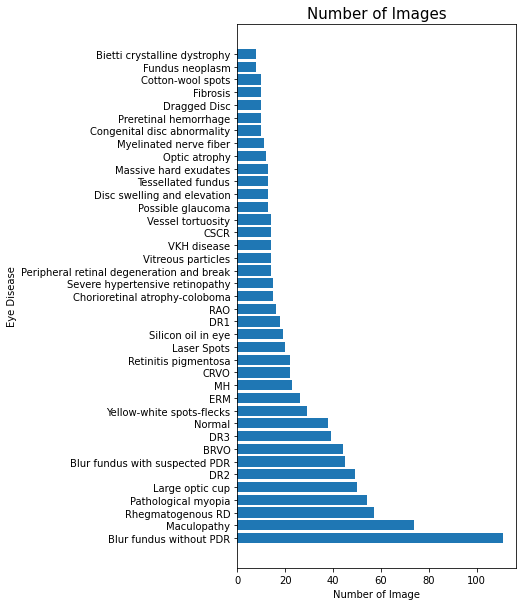

In [ ]:

counts = df['Folder'].value_counts()
plt.figure(figsize=(5,10))
ax = plt.barh(counts.index,counts.values)
#             , title="Number of Images" )
plt.title('Number of Images', fontsize=15)
plt.ylabel("Eye Disease")
plt.xlabel("Number of Image")
plt.show()

In [ ]:


# Add Lighting to the images for improving the visibility 

def draw_img_light(img, sigmaX=10):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128) # the trick is to add this line
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

In [ ]:
def image_resize(image_path, dim):
  img = cv2.imread(image_path)
  if img.shape[1] != img.shape[0]:
    x = img.shape[1]//2
    y = img.shape[0]//2
    x = x-y
    img = img[0:0+img.shape[0], x:x+img.shape[0]]
  # resize image
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  
def clahe(image_path, denoise=False, limit=None):
    bgr = cv2.imread(image_path)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=limit, tileGridSize=(16,32))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return bgr
    
def hist_eq(img):
    img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(img_y_cr_cb)
    img_eq = cv2.equalizeHist(y)
    img_y_cr_cb_eq = cv2.merge((img_eq, cr, cb))
    img_rgb_eq = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2BGR)
    #img=cv2.addWeighted (img_rgb_eq,4, cv2.GaussianBlur( img_rgb_eq , (0,0) , 224/10) ,-4 ,128) # the trick is to add this line 
    return img_rgb_eq


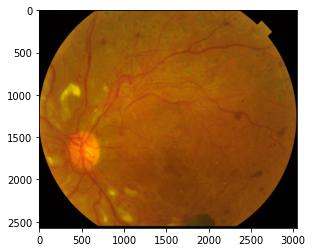

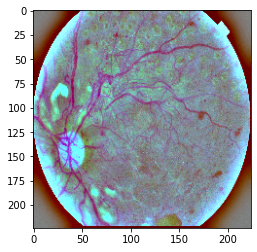

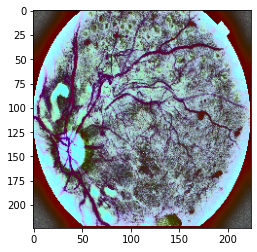

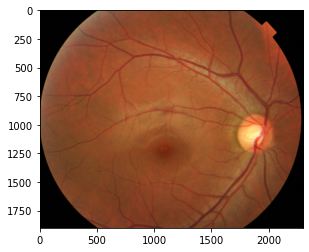

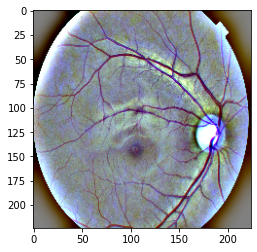

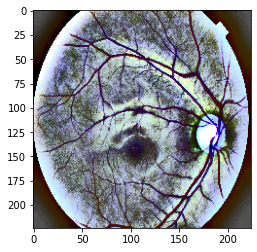

In [ ]:
img_file = './images/DR3/1ffa92e5-8d87-11e8-9daf-6045cb817f5b..JPG'

image = cv2.imread(img_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

plt.imshow(draw_img_light(image))
plt.show()

plt.imshow(hist_eq(draw_img_light(image)))
plt.show()

img_file = './images/Large optic cup/1ffa94d0-8d87-11e8-9daf-6045cb817f5b..JPG'
image = cv2.imread(img_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()
plt.imshow(draw_img_light(image))
plt.show()
plt.imshow(hist_eq(draw_img_light(image)))
plt.show()


In [ ]:
def check_images(image_dir, output_home):
  image_list, label_list = [], [] 
  Total = 0
  Removed_folder = 0
  Kept_folder = 0 
  if os.path.isdir(output_home):
      shutil.rmtree(output_home, ignore_errors=True)
      print("Directory '%s' has been removed successfully" %output_home) 
  if not os.path.isdir(output_home):
      os.mkdir(output_home)
      print("Directory '%s' has been created successfully" %output_home) 
  try:
      print("[INFO] Loading images ...")
      root_dir = listdir(image_dir)
      Total = len(root_dir)
      for directory in root_dir :
          # remove .DS_Store from list
          if directory == ".DS_Store" :
              root_dir.remove(directory)
          
      for disease_folder in root_dir :
          eye_disease_image_list = listdir(f"{image_dir}/{disease_folder}")
          eye_images = len(eye_disease_image_list)
          if eye_images > 19:
              Kept_folder = Kept_folder + 1
              print("Keeping Folder: {}".format(disease_folder))
              for single_eye_disease_image in eye_disease_image_list :
                  if single_eye_disease_image == ".DS_Store" :
                      eye_disease_image_list.remove(single_eye_disease_image)
                  else:
                      image_directory = f"{image_dir}/{disease_folder}/{single_eye_disease_image}"
                      if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                          #print(image_directory)
                          output_dir = f"{output_home}/{disease_folder}"
                          if not os.path.isdir(output_dir):
                              os.mkdir(output_dir)
                          output_file = os.path.join(output_dir, single_eye_disease_image)
                          copyfile(image_directory, output_file)
          else:
              Removed_folder = Removed_folder + 1
              print("Removing Folder: {} as it has {} images".format(disease_folder, eye_images))
      print("\n \n Out of Total:{} kept {} and removed {} directory".format(Total, Kept_folder, Removed_folder))

      print("[INFO] Image loading completed")  
  except Exception as e:
      print(f"Error : {e}")

In [ ]:



base_dir_mod = base_dir + "_test_224"
check_images(base_dir,base_dir_mod)

Directory './images_test_224' has been created successfully
[INFO] Loading images ...
Keeping Folder: BRVO
Keeping Folder: CRVO
Removing Folder: Chorioretinal atrophy-coloboma as it has 15 images
Removing Folder: Cotton-wool spots as it has 10 images
Removing Folder: Congenital disc abnormality as it has 10 images
Keeping Folder: Blur fundus without PDR
Keeping Folder: Blur fundus with suspected PDR
Removing Folder: CSCR as it has 14 images
Removing Folder: Disc swelling and elevation as it has 13 images
Removing Folder: Bietti crystalline dystrophy as it has 8 images
Keeping Folder: DR3
Keeping Folder: DR2
Removing Folder: Dragged Disc as it has 10 images
Keeping Folder: Large optic cup
Keeping Folder: ERM
Keeping Folder: Laser Spots
Keeping Folder: Maculopathy
Removing Folder: DR1 as it has 18 images
Removing Folder: Fibrosis as it has 10 images
Removing Folder: Fundus neoplasm as it has 8 images
Keeping Folder: Normal
Removing Folder: Massive hard exudates as it has 13 images
Removi

In [ ]:
data = []
for folder in sorted(os.listdir(base_dir_mod)):
    for file in sorted(os.listdir(base_dir_mod+"/"+folder)):
        data.append((folder, file))

df = pd.DataFrame(data, columns=['Folder', 'File'])

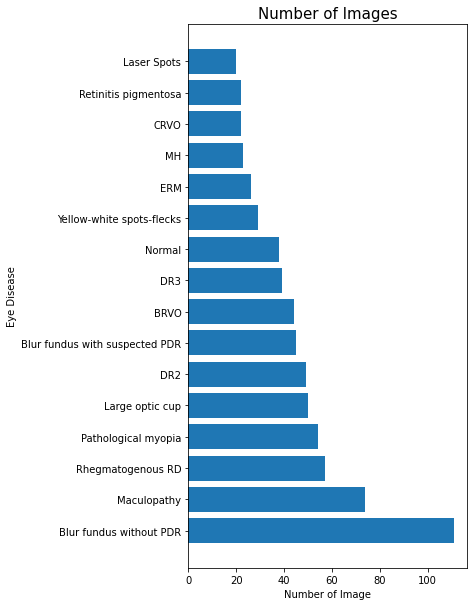

In [ ]:
counts = df['Folder'].value_counts()
plt.figure(figsize=(5,10))
ax = plt.barh(counts.index,counts.values)
#             , title="Number of Images" )
plt.title('Number of Images', fontsize=15)
plt.ylabel("Eye Disease")
plt.xlabel("Number of Image")
plt.show()

In [ ]:
#define croping function with tensorflow resize
def crop_image(image_path):
  image_data = tf.keras.preprocessing.image.load_img(image_path)
  
  array = tf.keras.preprocessing.image.img_to_array(image_data)
  image = tf.image.resize(
                        array, [224,224], 
                        method='bilinear',
                        preserve_aspect_ratio=True,
                        antialias=False,
                        )
  # image = image / 255.0
  return image

In [ ]:
def print_image(path, file_path):
    source = path + '/' + file_path
    test = crop_image(source)
    test = np.array(test)
    img = tf.keras.preprocessing.image.array_to_img(test)
    plt.imshow(img)
    test = np.expand_dims(test, axis=0)
    test.shape
    return None


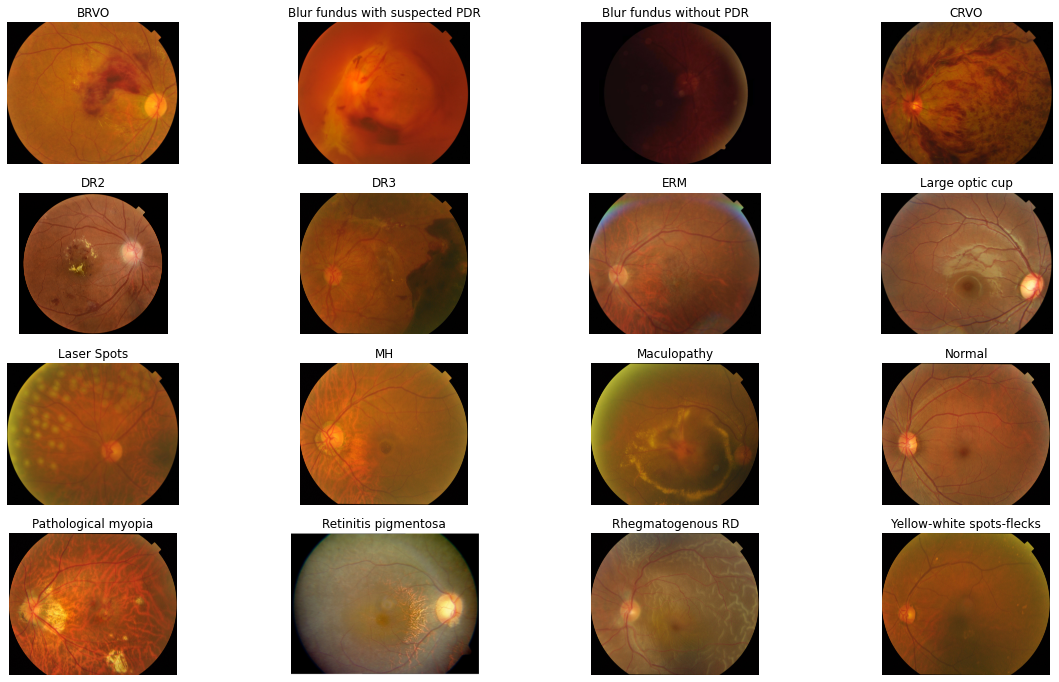

In [ ]:
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width,
                        figsize=(20, 12))
i = 0
label_name = ''
for index, row in df.iterrows():
    #print_image()
    if label_name == row['Folder']:
        pass
    else:
        source = base_dir_mod + '/' +row['Folder'] + '/' + row['File']
        #test = crop_image(source)
        #test = np.array(test)
        #img = tf.keras.preprocessing.image.array_to_img(test)
        ax = axs[int(i / grid_width), i % grid_width]
        image = cv2.imread(source)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.set_title(row['Folder'])
        #ax.set_title(str(label.item()))
        ax.axis('off')
        #plt.imshow(img)
        #plt.show()
        #test = np.expand_dims(test, axis=0)
        #test.shape
        label_name = row['Folder']
        i = i + 1
#plt.title('Sample Fundus Images for different classes', fontsize=15)
plt.show()

    
    



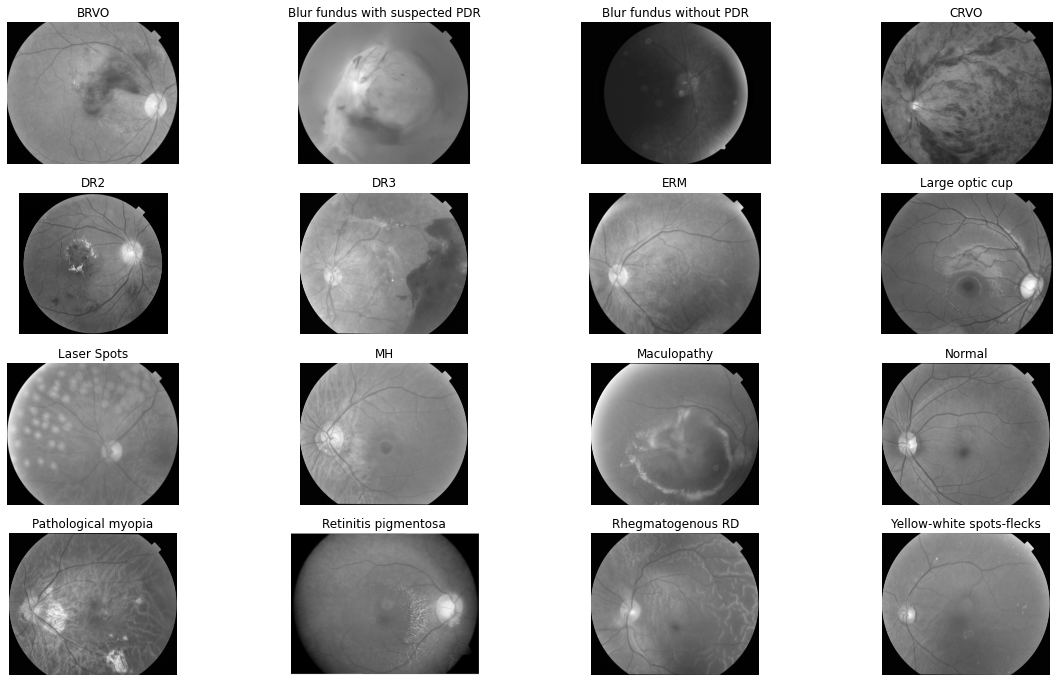

In [ ]:
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width,
                        figsize=(20, 12))
i = 0
label_name = ''
for index, row in df.iterrows():
    #print_image()
    if label_name == row['Folder']:
        pass
    else:
        source = base_dir_mod + '/' +row['Folder'] + '/' + row['File']
        #test = crop_image(source)
        #test = np.array(test)
        #img = tf.keras.preprocessing.image.array_to_img(test)
        ax = axs[int(i / grid_width), i % grid_width]
        image = cv2.imread(source)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ax.imshow(image, cmap='gray')
        ax.set_title(row['Folder'])
        #ax.set_title(str(label.item()))
        ax.axis('off')
        #plt.imshow(img)
        #plt.show()
        #test = np.expand_dims(test, axis=0)
        label_name = row['Folder']
        i = i + 1
#plt.title('Sample Fundus Images for different classes', fontsize=15)
plt.show()


In [ ]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [ ]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    #image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image


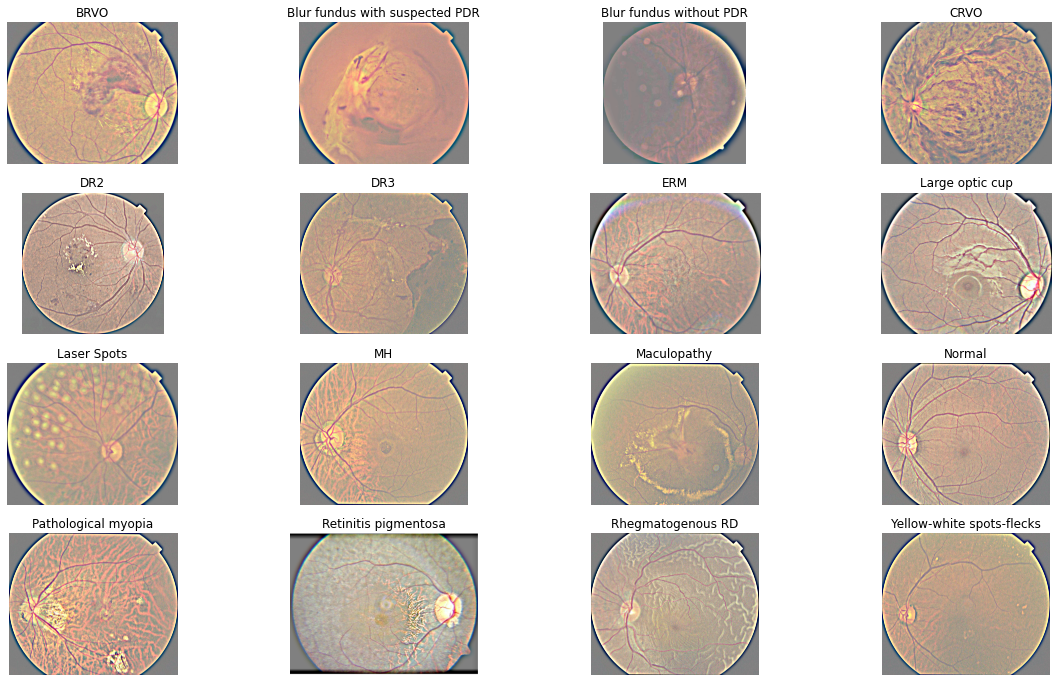

In [ ]:
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width,
                        figsize=(20, 12))
i = 0
label_name = ''
for index, row in df.iterrows():
    #print_image()
    if label_name == row['Folder']:
        pass
    else:
        source = base_dir_mod + '/' +row['Folder'] + '/' + row['File']
        #test = crop_image(source)
        #test = np.array(test)
        #img = tf.keras.preprocessing.image.array_to_img(test)
        ax = axs[int(i / grid_width), i % grid_width]
        image = load_ben_color(source,sigmaX=30)
        #image = cv2.imread(source)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ax.imshow(image, cmap='gray')
        ax.set_title(row['Folder'])
        #ax.set_title(str(label.item()))
        ax.axis('off')
        #plt.imshow(img)
        #plt.show()
        #test = np.expand_dims(test, axis=0)
#        test.shape
        label_name = row['Folder']
        i = i + 1
#plt.title('Sample Fundus Images for different classes', fontsize=15)
plt.show()


In [ ]:
def convert_image_to_array(image_dir, default_image_size):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print("Error :", e)
        return None

In [ ]:
def load_images(image_dir, default_image_size):
  image_list, label_list = [], [] 
  Total = 0
  Removed_folder = 0
  Kept_folder = 0 
  try:
      print("[INFO] Loading images ...")
      root_dir = listdir(image_dir)
      Total = len(root_dir)
      for directory in root_dir :
          # remove .DS_Store from list
          if directory == ".DS_Store" :
              root_dir.remove(directory)
          
      for disease_folder in root_dir :
          eye_disease_image_list = listdir(f"{image_dir}/{disease_folder}")
          eye_images = len(eye_disease_image_list)
          print(f"[INFO] Processing {disease_folder} ...")
          for single_eye_disease_image in eye_disease_image_list :
              if single_eye_disease_image == ".DS_Store" :
                  eye_disease_image_list.remove(single_eye_disease_image)
              else:
                  image_directory = f"{image_dir}/{disease_folder}/{single_eye_disease_image}"
                  if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                      #print(image_directory)
                      image_list.append(convert_image_to_array(image_directory, default_image_size))
                      label_list.append(disease_folder)
                                
      print("[INFO] Image loading completed")  
  except Exception as e:
      print(f"Error : {e}")
  return image_list, label_list

In [ ]:
image_list, label_list = load_images(base_dir_mod, default_image_size)

[INFO] Loading images ...
[INFO] Processing BRVO ...
[INFO] Processing CRVO ...
[INFO] Processing Blur fundus without PDR ...
[INFO] Processing Blur fundus with suspected PDR ...
[INFO] Processing DR3 ...
[INFO] Processing DR2 ...
[INFO] Processing Large optic cup ...
[INFO] Processing ERM ...
[INFO] Processing Laser Spots ...
[INFO] Processing Maculopathy ...
[INFO] Processing Normal ...
[INFO] Processing MH ...
[INFO] Processing Pathological myopia ...
[INFO] Processing Retinitis pigmentosa ...
[INFO] Processing Yellow-white spots-flecks ...
[INFO] Processing Rhegmatogenous RD ...
[INFO] Image loading completed


In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print(image_labels)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]


In [ ]:
print(label_binarizer.classes_)

['BRVO' 'Blur fundus with suspected PDR' 'Blur fundus without PDR' 'CRVO'
 'DR2' 'DR3' 'ERM' 'Large optic cup' 'Laser Spots' 'MH' 'Maculopathy'
 'Normal' 'Pathological myopia' 'Retinitis pigmentosa' 'Rhegmatogenous RD'
 'Yellow-white spots-flecks']


In [ ]:
#--np_image_list = np.array(image_list, dtype=np.float16) / 255.0
#--print("[INFO] Spliting data to train, test")
#--x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 64)

In [ ]:
#IMAGE_SIZE = 224
#BATCH_SIZE = 32

#datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
#                                                             rotation_range=10,
#                                                             shear_range = 10,
#                                                             zoom_range = 0.1,
#                                                            brightness_range=[0.2,1.0],
#                                                             horizontal_flip=True,
#                                                             vertical_flip=True,
#                                                             validation_split = 0.2,
#                                                            dtype=np.float32,
#                                                             fill_mode='constant'
#                                                             )


#train_generator = datagen.flow_from_directory(
#    base_dir,
#    target_size=(IMAGE_SIZE, IMAGE_SIZE),
#    batch_size=BATCH_SIZE, 
#    subset='training')

#val_generator = datagen.flow_from_directory(
#    base_dir,
#    target_size=(IMAGE_SIZE, IMAGE_SIZE),
#    batch_size=BATCH_SIZE, 
#    subset='validation')


In [ ]:
def load_ben_color_img(image, sigmaX=10):
    #image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    #image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [ ]:
def convert(image_dir, output_home, limit=None):
  image_list, label_list = [], []
  if os.path.isdir(output_home):
      shutil.rmtree(output_home, ignore_errors=True)
      print("Directory '%s' has been removed successfully" %output_home) 
  if not os.path.isdir(output_home):
      os.mkdir(output_home)
      print("Directory '%s' has been created successfully" %output_home) 
  try:
      print("[INFO] Loading images ...")
      root_dir = listdir(image_dir)
      print(root_dir)
      for directory in root_dir :
          # remove .DS_Store from list
          if directory == ".DS_Store" :
              root_dir.remove(directory)
          
      for disease_folder in root_dir :
          eye_disease_image_list = listdir(f"{image_dir}/{disease_folder}")
          print(eye_disease_image_list)
          for single_eye_disease_image in eye_disease_image_list :
              if single_eye_disease_image == ".DS_Store" :
                  eye_disease_image_list.remove(single_eye_disease_image)
              else:
                  image_directory = f"{image_dir}/{disease_folder}/{single_eye_disease_image}"
                  if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                      print(image_directory)
                    
                      bgr = clahe(image_directory, limit=limit)
                      bgr = hist_eq(bgr)
                      #green_image = bgr.copy()
                      #green_image[:,:,0] = 0
                      #green_image[:,:,2] = 0
                      #bgr = green_image
                      #bgr = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
                      #bgr = load_ben_color_img(bgr,sigmaX=30)
                      bgr = crop_image_from_gray(bgr)


                      output_dir = f"{output_home}/{disease_folder}"
                      if not os.path.isdir(output_dir):
                          os.mkdir(output_dir)
                      output_file = os.path.join(output_dir, single_eye_disease_image)
                      cv2.imwrite(output_file, bgr)

      print("[INFO] Image loading completed")  
  except Exception as e:
      print(f"Error : {e}")

In [ ]:
base_dir_mod
output_home_dir = "./images_modified_224"
limit = 2.0
convert(base_dir_mod, output_home_dir, limit=limit)

Directory './images_modified_224' has been removed successfully
Directory './images_modified_224' has been created successfully
[INFO] Loading images ...
['BRVO', 'CRVO', 'Blur fundus without PDR', 'Blur fundus with suspected PDR', 'DR3', 'DR2', 'Large optic cup', 'ERM', 'Laser Spots', 'Maculopathy', 'Normal', 'MH', 'Pathological myopia', 'Retinitis pigmentosa', 'Yellow-white spots-flecks', 'Rhegmatogenous RD']
['1ffa95f2-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa95f1-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa95f4-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa95f3-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa9611-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa960f-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa95fb-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa9606-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa95fd-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa9601-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa9608-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa9604-8d87-11e8-9daf-6045cb817f5b..JPG', '1ffa9603-8d87-11e8-9daf-6045cb817f5b..JPG',

In [12]:
base_dir = "./images_modified_224"

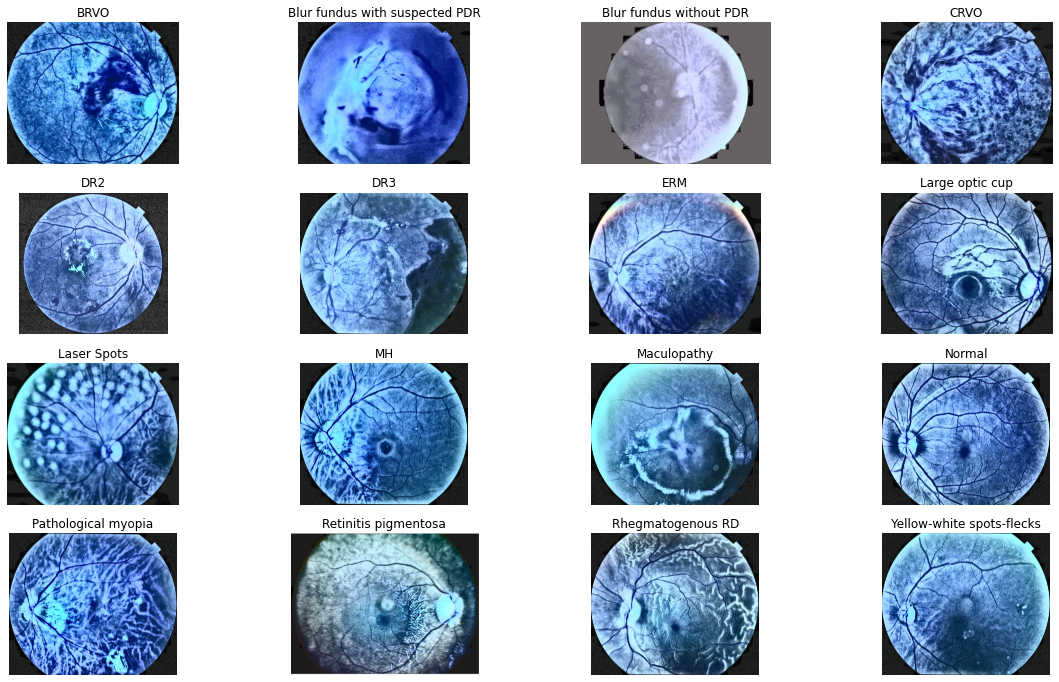

In [ ]:
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width,
                        figsize=(20, 12))
i = 0
label_name = ''
for index, row in df.iterrows():
    #print_image()
    if label_name == row['Folder']:
        pass
    else:
        source = base_dir + '/' +row['Folder'] + '/' + row['File']
        #test = crop_image(source)
        #test = np.array(test)
        #img = tf.keras.preprocessing.image.array_to_img(test)
        ax = axs[int(i / grid_width), i % grid_width]
        #image = load_ben_color(source,sigmaX=30)
        image = cv2.imread(source)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ax.imshow(image)
        ax.set_title(row['Folder'])
        #ax.set_title(str(label.item()))
        ax.axis('off')
        #plt.imshow(img)
        #plt.show()
        #test = np.expand_dims(test, axis=0)

        label_name = row['Folder']
        i = i + 1
#plt.title('Sample Fundus Images for different classes', fontsize=15)
plt.show()


In [9]:
base_dir = "./images_modified_224"
IMAGE_SIZE = 224
BATCH_SIZE = 32

datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                             rotation_range=45,
                                                             shear_range = 0.1,
                                                             zoom_range = 0.2,
                                                            brightness_range=[0.2,1.0],
                                                             horizontal_flip=True,
                                                             vertical_flip=True,
                                                             validation_split = 0.2,
                                                            dtype=np.float32,
                                                             fill_mode='constant'
                                                             )


train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')


Found 570 images belonging to 16 classes.
Found 133 images belonging to 16 classes.


In [10]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 16))

In [11]:
Diseases = list(train_generator.class_indices.keys())
print(Diseases)

['BRVO', 'Blur fundus with suspected PDR', 'Blur fundus without PDR', 'CRVO', 'DR2', 'DR3', 'ERM', 'Large optic cup', 'Laser Spots', 'MH', 'Maculopathy', 'Normal', 'Pathological myopia', 'Retinitis pigmentosa', 'Rhegmatogenous RD', 'Yellow-white spots-flecks']


In [13]:
Diseases = list(train_generator.class_indices.keys())
print(Diseases)

['BRVO', 'Blur fundus with suspected PDR', 'Blur fundus without PDR', 'CRVO', 'DR2', 'DR3', 'ERM', 'Large optic cup', 'Laser Spots', 'MH', 'Maculopathy', 'Normal', 'Pathological myopia', 'Retinitis pigmentosa', 'Rhegmatogenous RD', 'Yellow-white spots-flecks']


In [14]:



labels = "\n".join(sorted(train_generator.class_indices.keys()))

with open("labels.txt", "w") as f:
    f.write(labels)

In [15]:
# Number of images for each disease
nums = {}
for disease in Diseases:
    nums[disease] = len(os.listdir(base_dir + '/' + disease))
print(nums)

{'BRVO': 44, 'Blur fundus with suspected PDR': 45, 'Blur fundus without PDR': 111, 'CRVO': 22, 'DR2': 49, 'DR3': 39, 'ERM': 26, 'Large optic cup': 50, 'Laser Spots': 20, 'MH': 23, 'Maculopathy': 74, 'Normal': 38, 'Pathological myopia': 54, 'Retinitis pigmentosa': 22, 'Rhegmatogenous RD': 57, 'Yellow-white spots-flecks': 29}


In [16]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
    x = Conv2D(32, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)

In [27]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50
def get_model_resnet():
  base_model = ResNet50(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  #x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_resnet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False


In [28]:
#SVG(tf.keras.utils.model_to_dot(model, dpi=70, show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, subgraph=False).create(prog='dot', format='svg'))

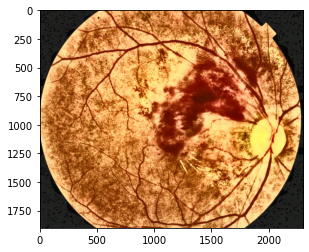

In [29]:
# Take one image to visualize it's changes after every layer
from keras.preprocessing import image
import numpy as np
img1 = image.load_img('./images_modified/BRVO/1ffa95f1-8d87-11e8-9daf-6045cb817f5b..JPG')
plt.imshow(img1);

#preprocess image
img1 = image.load_img('./images_modified/BRVO/1ffa95f1-8d87-11e8-9daf-6045cb817f5b..JPG', target_size=(IMAGE_SIZE, IMAGE_SIZE))
img = image.img_to_array(img1)
img = img/255
img = np.expand_dims(img, axis=0)

In [30]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50
def get_model_resnet():
  base_model = ResNet50(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  #x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_resnet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False



In [31]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 8,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)



Epoch 1/50
18/18 [==============================] - 89s 5s/step - loss: 2.7182 - accuracy: 0.1649 - val_loss: 2.7771 - val_accuracy: 0.1654
Epoch 2/50
18/18 [==============================] - 81s 5s/step - loss: 2.3043 - accuracy: 0.2789 - val_loss: 2.7599 - val_accuracy: 0.0526
Epoch 3/50
18/18 [==============================] - 80s 4s/step - loss: 2.1246 - accuracy: 0.3093 - val_loss: 2.7690 - val_accuracy: 0.0602
Epoch 4/50
18/18 [==============================] - 80s 4s/step - loss: 2.0096 - accuracy: 0.3337 - val_loss: 2.7637 - val_accuracy: 0.1278
Epoch 5/50
18/18 [==============================] - 80s 4s/step - loss: 2.1141 - accuracy: 0.2977 - val_loss: 2.7893 - val_accuracy: 0.0977
Epoch 6/50
18/18 [==============================] - 80s 4s/step - loss: 1.9416 - accuracy: 0.3691 - val_loss: 2.7609 - val_accuracy: 0.1128
Epoch 7/50
18/18 [==============================] - 80s 4s/step - loss: 1.9124 - accuracy: 0.3645 - val_loss: 3.0542 - val_accuracy: 0.1504
Epoch 8/50
18/18 [==

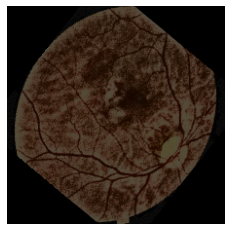

True label: Maculopathy
Predicted label: Normal


In [32]:
def get_class_string_from_index(index):
   for class_string, class_index in val_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(val_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [33]:
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('resnet_adam.h5')

Test loss: 1.6885348558425903
Test Accuracy: 0.4285714328289032


Confusion Matrix
[[0 0 2 0 1 1 0 0 0 0 0 2 1 0 1 0]
 [0 0 3 0 0 0 0 0 0 0 1 4 1 0 0 0]
 [1 1 3 0 0 0 0 1 0 0 2 5 2 0 7 0]
 [0 0 2 0 0 0 0 0 0 0 0 1 0 0 1 0]
 [0 0 2 0 1 0 0 0 0 0 1 0 1 0 4 0]
 [0 0 1 0 0 0 0 0 0 0 0 2 1 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 2 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 3 2 0 0 4 0]
 [0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1]
 [0 0 1 0 1 0 0 1 0 0 1 4 1 0 4 1]
 [0 1 1 1 1 0 0 0 0 0 1 0 0 0 2 0]
 [0 0 1 0 0 0 0 0 0 0 1 2 1 0 5 0]
 [0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 2 1 0 0 0 1 0 0 0 6 1 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 2 0]]



F1 Score macro 0.026554531653976608
F1 Score micro 0.045112781954887216
F1 Score weighted 0.04477442806475379
accuracy_score  0.045112781954887216
precision_score  0.027932692307692304
recall_score  0.02618145743145743
mean_squared_error  48.962406015037594


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



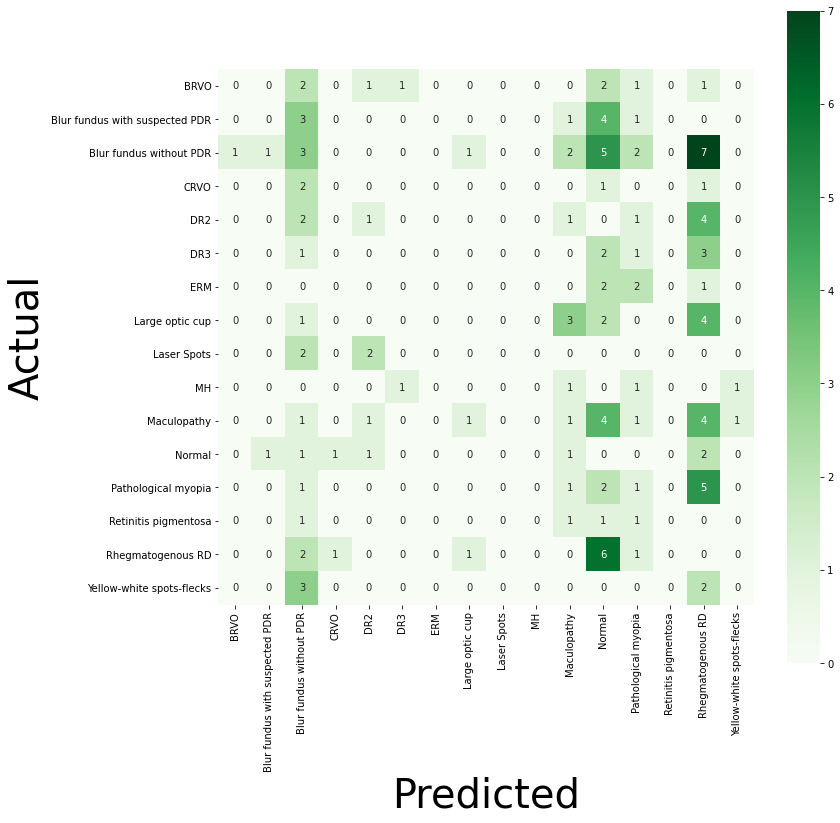

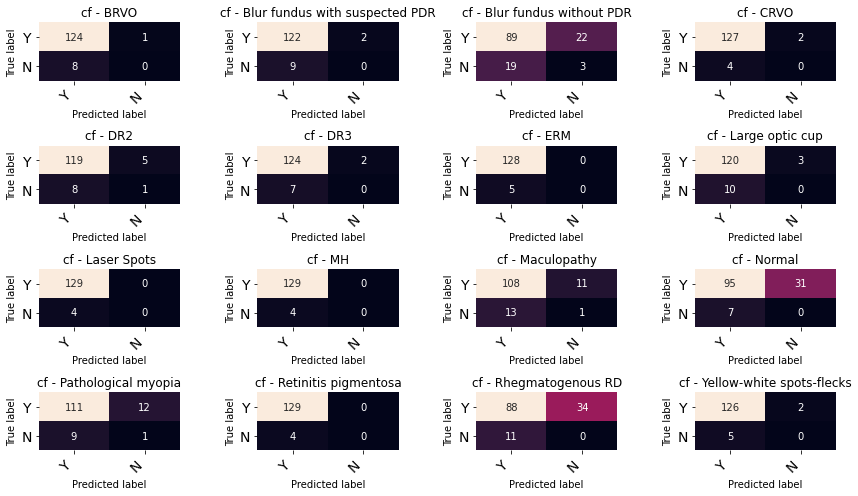

In [34]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("cf - " + class_label)
fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

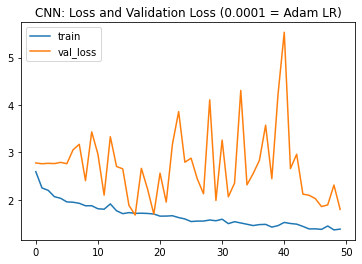

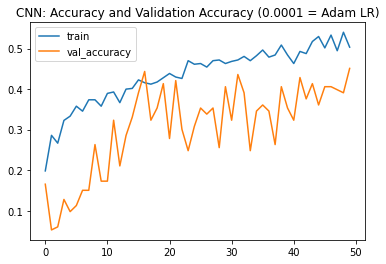

In [35]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = Adam LR)')
plt.legend();
plt.show()

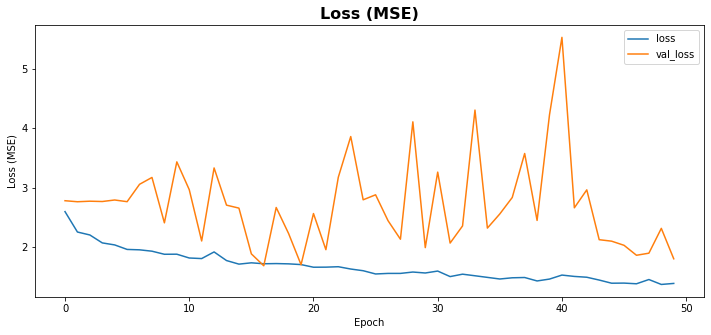

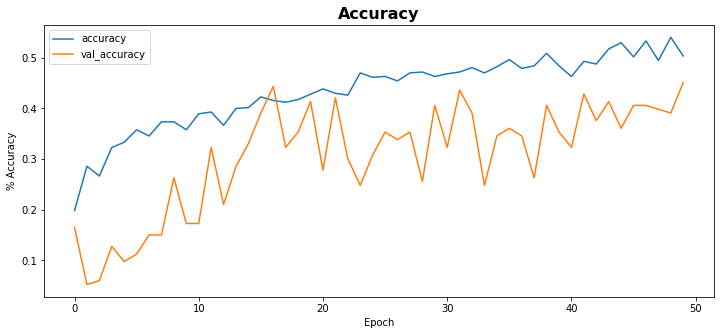

In [36]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");

In [37]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50
def get_model_resnet():
  base_model = ResNet50(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  #x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_resnet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [38]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.Adamax(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)


Epoch 1/50
18/18 [==============================] - 85s 5s/step - loss: 2.7029 - accuracy: 0.1735 - val_loss: 2.8964 - val_accuracy: 0.0602
Epoch 2/50
18/18 [==============================] - 78s 4s/step - loss: 2.3430 - accuracy: 0.2582 - val_loss: 2.8803 - val_accuracy: 0.0602
Epoch 3/50
18/18 [==============================] - 78s 4s/step - loss: 2.2341 - accuracy: 0.2983 - val_loss: 2.8308 - val_accuracy: 0.0602
Epoch 4/50
18/18 [==============================] - 79s 4s/step - loss: 2.1549 - accuracy: 0.3130 - val_loss: 2.8043 - val_accuracy: 0.0602
Epoch 5/50
18/18 [==============================] - 78s 4s/step - loss: 2.0102 - accuracy: 0.3028 - val_loss: 2.7856 - val_accuracy: 0.0602
Epoch 6/50
18/18 [==============================] - 78s 4s/step - loss: 1.8976 - accuracy: 0.3830 - val_loss: 2.7506 - val_accuracy: 0.0602
Epoch 7/50
18/18 [==============================] - 78s 4s/step - loss: 1.9337 - accuracy: 0.3593 - val_loss: 2.6622 - val_accuracy: 0.0752
Epoch 8/50
18/18 [==

In [39]:
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('resnet_adamax.h5')

Test loss: 1.7259894609451294
Test Accuracy: 0.42105263471603394


Confusion Matrix
[[0 1 0 1 0 0 0 0 0 0 3 1 2 0 0 0]
 [0 3 0 0 0 0 0 1 0 0 2 1 1 0 1 0]
 [0 5 1 0 1 0 0 1 0 0 7 2 2 0 3 0]
 [0 1 0 0 0 1 0 0 0 0 2 0 0 0 0 0]
 [0 1 1 0 1 1 0 1 0 0 1 1 1 0 0 1]
 [0 1 0 0 0 2 0 0 0 0 3 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 2 0 2 0 0 0]
 [0 2 2 0 0 0 0 0 0 0 2 0 3 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0]
 [0 3 2 0 0 0 0 0 0 0 5 0 3 0 1 0]
 [0 0 0 0 0 1 0 3 0 0 3 0 0 0 0 0]
 [0 2 1 0 1 0 0 0 0 0 4 1 1 0 0 0]
 [1 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 2 2 1 0 2 0 0 0 0 2 0 1 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 1 0 1 0 2 0]]



F1 Score macro 0.06360017297517298
F1 Score micro 0.10526315789473684
F1 Score weighted 0.07985458915910043
accuracy_score  0.10526315789473684
precision_score  0.06283967391304349
recall_score  0.08272907647907649
mean_squared_error  46.285714285714285


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



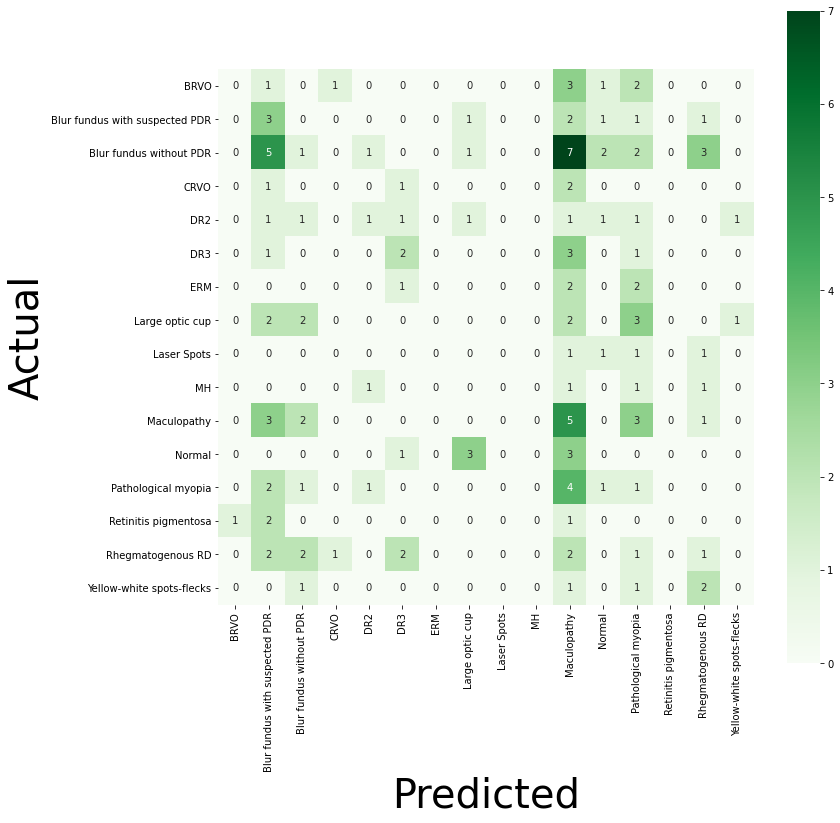

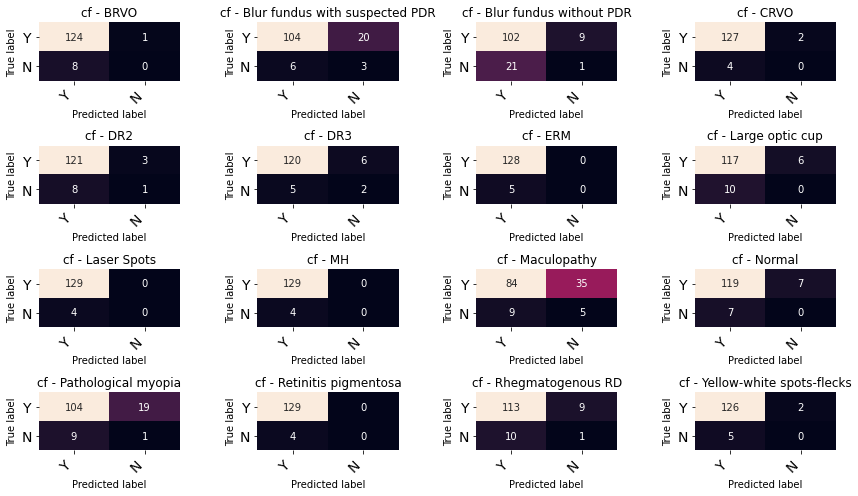

In [40]:
import sklearn.metrics
import seaborn as sns
y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

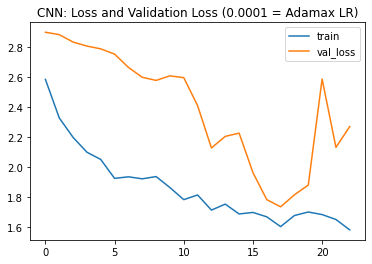

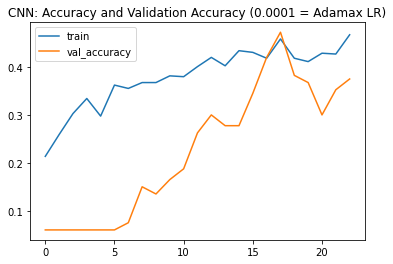

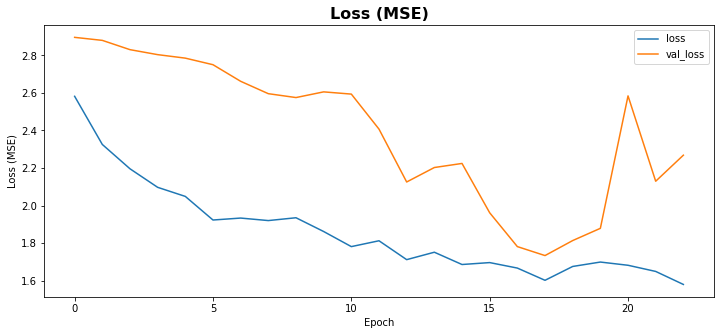

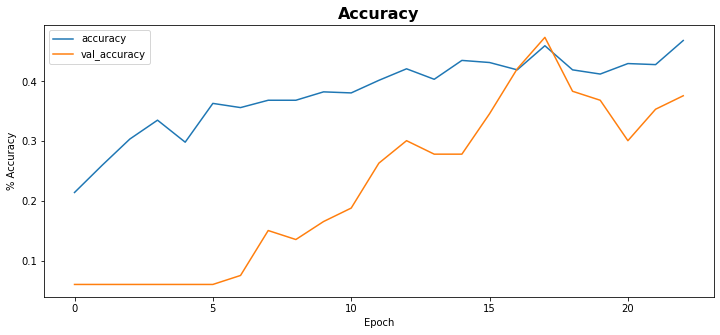

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = Adamax LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = Adamax LR)')
plt.legend();
plt.show()


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy")
plt.show()

In [42]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50
def get_model_resnet():
  base_model = ResNet50(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  #x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_resnet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [43]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.RMSprop(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)

Epoch 1/50
18/18 [==============================] - 88s 5s/step - loss: 2.8121 - accuracy: 0.1545 - val_loss: 2.8356 - val_accuracy: 0.0752
Epoch 2/50
18/18 [==============================] - 79s 4s/step - loss: 2.4164 - accuracy: 0.2494 - val_loss: 2.8687 - val_accuracy: 0.0677
Epoch 3/50
18/18 [==============================] - 77s 4s/step - loss: 2.3286 - accuracy: 0.2794 - val_loss: 2.7988 - val_accuracy: 0.0602
Epoch 4/50
18/18 [==============================] - 78s 4s/step - loss: 2.1571 - accuracy: 0.2638 - val_loss: 2.7218 - val_accuracy: 0.0677
Epoch 5/50
18/18 [==============================] - 79s 4s/step - loss: 2.1755 - accuracy: 0.2543 - val_loss: 2.6182 - val_accuracy: 0.1805
Epoch 6/50
18/18 [==============================] - 79s 4s/step - loss: 2.0931 - accuracy: 0.3308 - val_loss: 2.3449 - val_accuracy: 0.3158
Epoch 7/50
18/18 [==============================] - 79s 4s/step - loss: 2.0121 - accuracy: 0.3132 - val_loss: 2.3340 - val_accuracy: 0.2030
Epoch 8/50
18/18 [==

In [44]:
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('resnet_RMSProp.h5')

Test loss: 2.158057689666748
Test Accuracy: 0.27067670226097107


Confusion Matrix
[[ 0  0  0  0  0  1  0  2  0  1  4  0  0  0  0  0]
 [ 0  0  3  0  0  1  0  0  0  0  3  2  0  0  0  0]
 [ 0  1  1  0  0  3  0  3  0  0 14  0  0  0  0  0]
 [ 0  0  1  1  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  2  1  0  0  0  0  5  0  0  0  1  0  0  0  0]
 [ 0  1  0  0  0  1  0  2  0  0  2  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  1  0  2  0  0  0  0]
 [ 1  0  1  0  0  1  0  2  0  1  4  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  2  1  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  0  1  0  0  0  0  0]
 [ 0  0  2  0  0  3  0  5  0  0  2  2  0  0  0  0]
 [ 0  0  1  0  0  1  0  1  0  0  2  2  0  0  0  0]
 [ 0  0  0  0  0  2  0  3  0  2  2  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  1  0  1  1  0  1  0  0  0]
 [ 0  0  0  1  0  3  0  3  0  0  3  0  0  0  1  0]
 [ 0  0  1  0  0  2  0  0  0  0  2  0  0  0  0  0]]



F1 Score macro 0.06399718576442714
F1 Score micro 0.07518796992481203
F1 Score weighted 0.06399936306599516
accuracy_score  0.07518796992481203
precision_score  0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



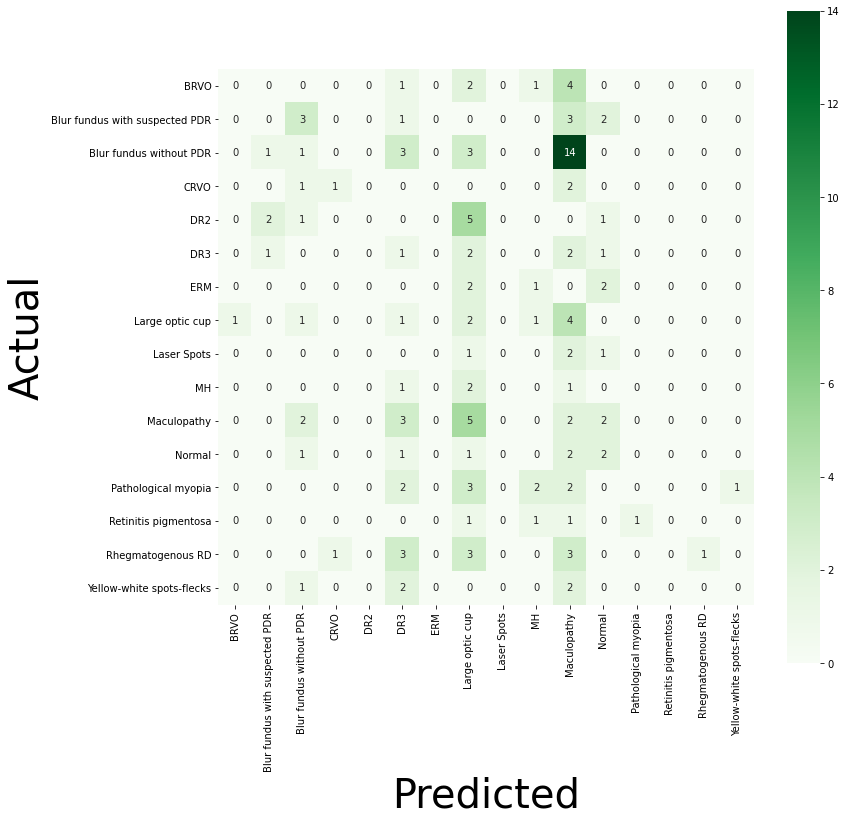

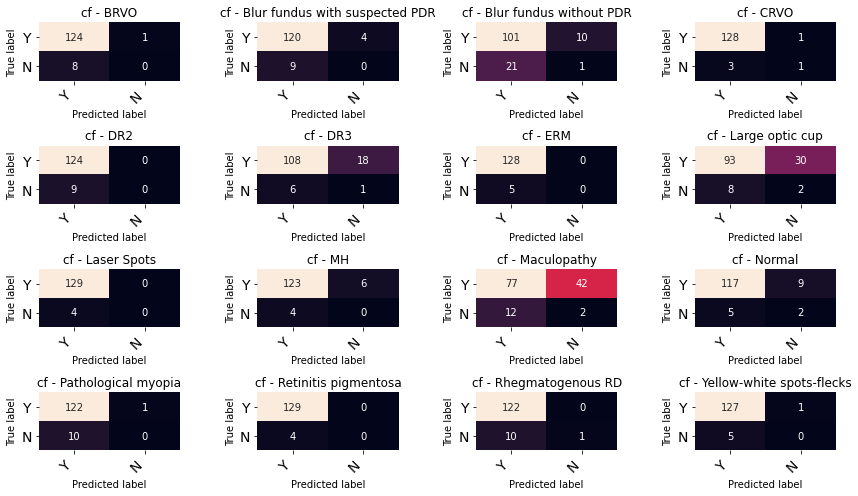

In [45]:
import sklearn.metrics
import seaborn as sns
y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

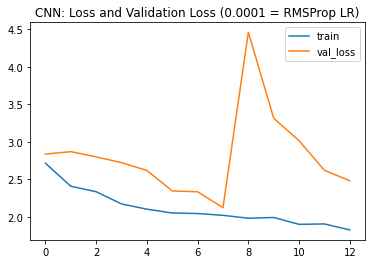

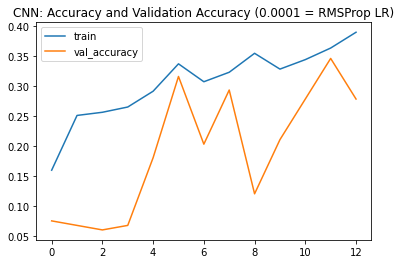

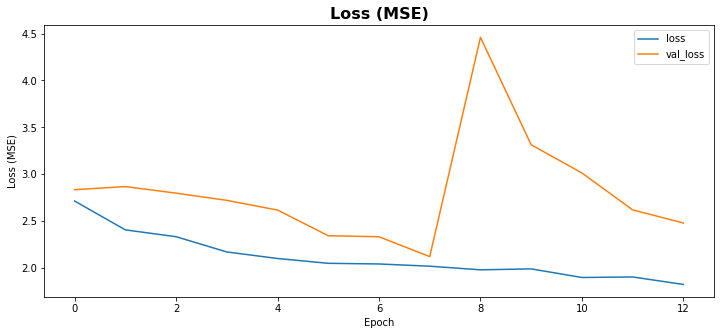

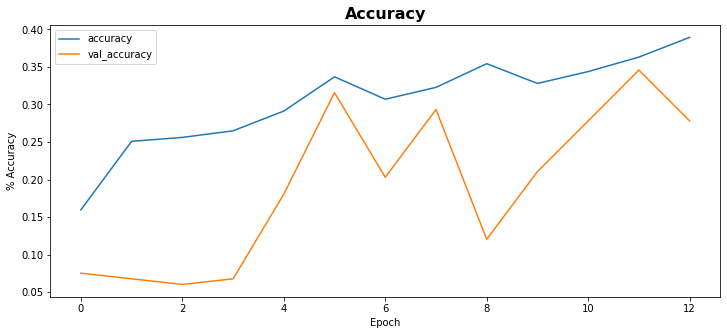

In [46]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = RMSProp LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = RMSProp LR)')
plt.legend();
plt.show()


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy")
plt.show()

In [47]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50
def get_model_resnet():
  base_model = ResNet50(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  #x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_resnet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [48]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)


Epoch 1/50
18/18 [==============================] - 85s 5s/step - loss: 3.0935 - accuracy: 0.0390 - val_loss: 3.3120 - val_accuracy: 0.0526
Epoch 2/50
18/18 [==============================] - 77s 4s/step - loss: 2.7324 - accuracy: 0.1483 - val_loss: 3.1664 - val_accuracy: 0.0526
Epoch 3/50
18/18 [==============================] - 78s 4s/step - loss: 2.5556 - accuracy: 0.1975 - val_loss: 3.0509 - val_accuracy: 0.0902
Epoch 4/50
18/18 [==============================] - 78s 4s/step - loss: 2.4771 - accuracy: 0.2258 - val_loss: 3.0030 - val_accuracy: 0.0602
Epoch 5/50
18/18 [==============================] - 78s 4s/step - loss: 2.4207 - accuracy: 0.2693 - val_loss: 2.9356 - val_accuracy: 0.0677
Epoch 6/50
18/18 [==============================] - 78s 4s/step - loss: 2.3931 - accuracy: 0.2571 - val_loss: 2.8838 - val_accuracy: 0.0827
Epoch 7/50
18/18 [==============================] - 78s 4s/step - loss: 2.3888 - accuracy: 0.2645 - val_loss: 2.8269 - val_accuracy: 0.0677
Epoch 8/50
18/18 [==

In [49]:
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('resnet_SGD.h5')


Test loss: 1.991432785987854
Test Accuracy: 0.36090224981307983


Confusion Matrix
[[0 0 4 0 0 0 0 1 0 0 0 1 0 0 1 1]
 [0 1 4 0 0 0 0 0 0 0 2 2 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0 8 0 4 0 2 0]
 [0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0]
 [0 0 2 0 0 0 0 1 0 0 3 0 2 0 1 0]
 [0 0 1 0 0 0 0 1 0 0 2 0 2 0 1 0]
 [0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0]
 [0 0 2 0 0 0 0 1 0 0 1 0 4 0 2 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 4 0 0 0 0 3 0 0 3 1 1 0 2 0]
 [0 0 2 0 0 0 0 0 0 0 3 0 1 0 1 0]
 [0 1 1 0 0 0 0 1 0 0 5 1 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0]
 [0 0 5 0 0 0 0 1 0 0 3 0 1 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 2 0 0 0 2 0]]



F1 Score macro 0.04879122861265718
F1 Score micro 0.11278195488721804
F1 Score weighted 0.08464169080710433
accuracy_score  0.11278195488721804
precision_score  0.05118321718931475
recall_score  0.0612463924963925
mean_squared_error  40.41353383458647


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



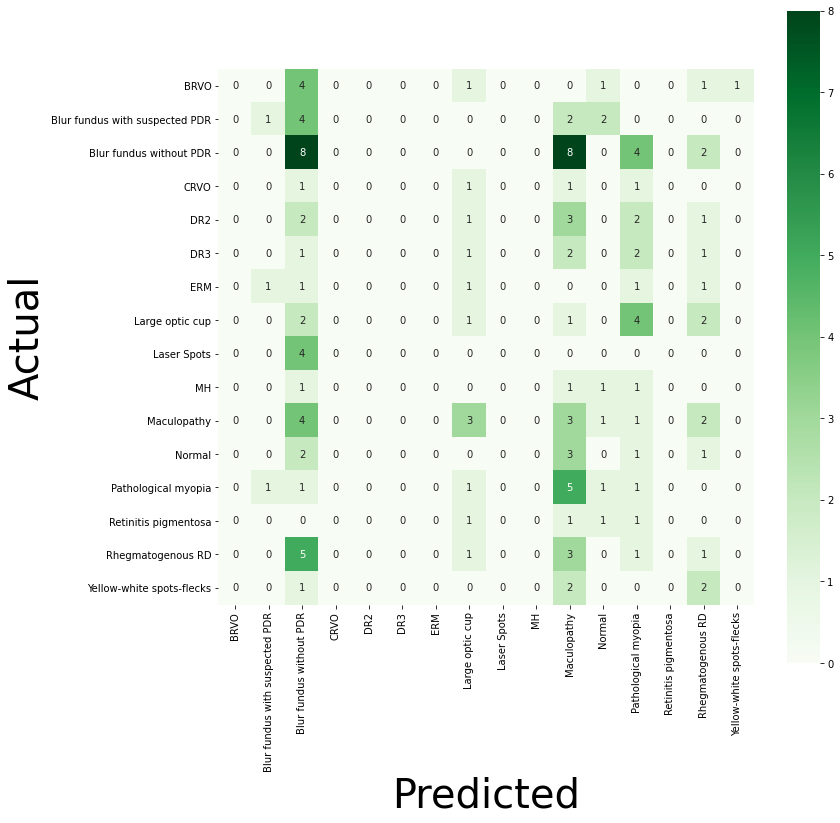

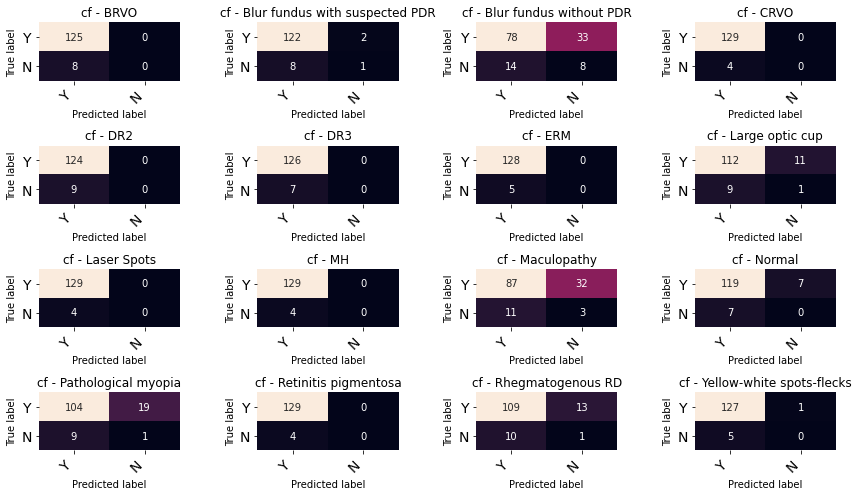

In [50]:
import sklearn.metrics
import seaborn as sns
y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

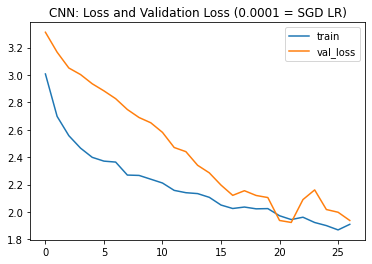

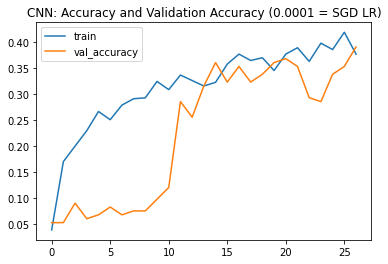

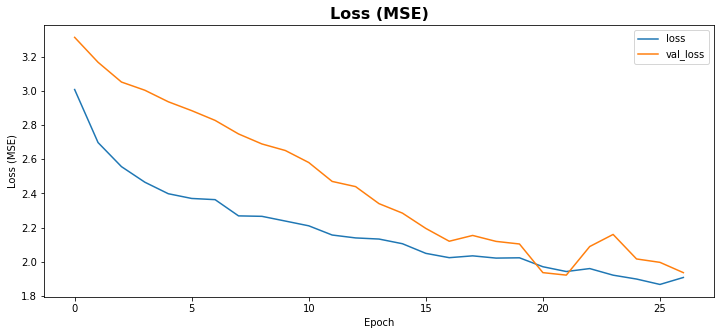

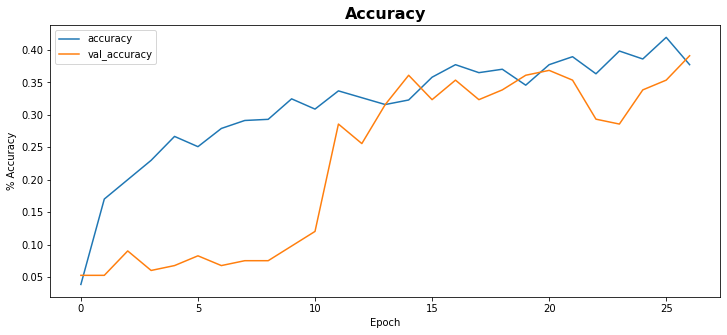

In [51]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = SGD LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = SGD LR)')
plt.legend();
plt.show()


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");
plt.show()

In [52]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50
def get_model_resnet():
  base_model = ResNet50(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  #x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_resnet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [53]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 8,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)

Epoch 1/50
18/18 [==============================] - 86s 5s/step - loss: 3.4638 - accuracy: 0.0995 - val_loss: 58.3506 - val_accuracy: 0.0827
Epoch 2/50
18/18 [==============================] - 79s 4s/step - loss: 2.5269 - accuracy: 0.2235 - val_loss: 50.8234 - val_accuracy: 0.0827
Epoch 3/50
18/18 [==============================] - 79s 4s/step - loss: 2.2949 - accuracy: 0.2766 - val_loss: 36.2687 - val_accuracy: 0.1128
Epoch 4/50
18/18 [==============================] - 79s 4s/step - loss: 2.2368 - accuracy: 0.2841 - val_loss: 103.2190 - val_accuracy: 0.0526
Epoch 5/50
18/18 [==============================] - 80s 5s/step - loss: 2.2022 - accuracy: 0.2806 - val_loss: 75.9013 - val_accuracy: 0.0602
Epoch 6/50
18/18 [==============================] - 78s 4s/step - loss: 2.2118 - accuracy: 0.2746 - val_loss: 92.7682 - val_accuracy: 0.1654
Epoch 7/50
18/18 [==============================] - 78s 4s/step - loss: 2.2146 - accuracy: 0.2482 - val_loss: 116.4879 - val_accuracy: 0.2180
Epoch 8/50


In [54]:
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('resnet_adam.h5')

Test loss: 4.929333686828613
Test Accuracy: 0.2857142984867096


Confusion Matrix
[[0 0 2 0 0 0 0 2 0 0 0 1 0 0 3 0]
 [0 0 4 0 0 0 0 2 0 0 0 0 1 0 2 0]
 [2 0 5 0 0 0 0 6 0 0 0 3 1 0 5 0]
 [2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 2 0 0 0 2 0 0 4 0]
 [0 0 0 0 0 0 0 4 0 0 0 0 0 0 3 0]
 [0 0 2 0 0 0 0 1 0 0 0 0 0 0 2 0]
 [0 0 5 0 0 0 0 2 0 0 0 1 0 0 2 0]
 [0 0 1 0 0 0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 1 0 0 2 0]
 [1 0 4 0 0 0 0 5 0 0 0 1 0 0 3 0]
 [0 0 1 0 0 0 0 2 0 0 0 0 2 0 2 0]
 [0 0 2 0 0 0 0 2 0 0 0 2 1 0 3 0]
 [0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [1 1 3 0 0 0 0 2 0 0 0 2 0 0 2 0]
 [0 0 1 0 0 0 0 2 0 0 0 2 0 0 0 0]]



F1 Score macro 0.030535619351408826
F1 Score micro 0.07518796992481203
F1 Score weighted 0.05324715297014466
accuracy_score  0.07518796992481203
precision_score  0.02878787878787879
recall_score  0.04431818181818182
mean_squared_error  47.32330827067669


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



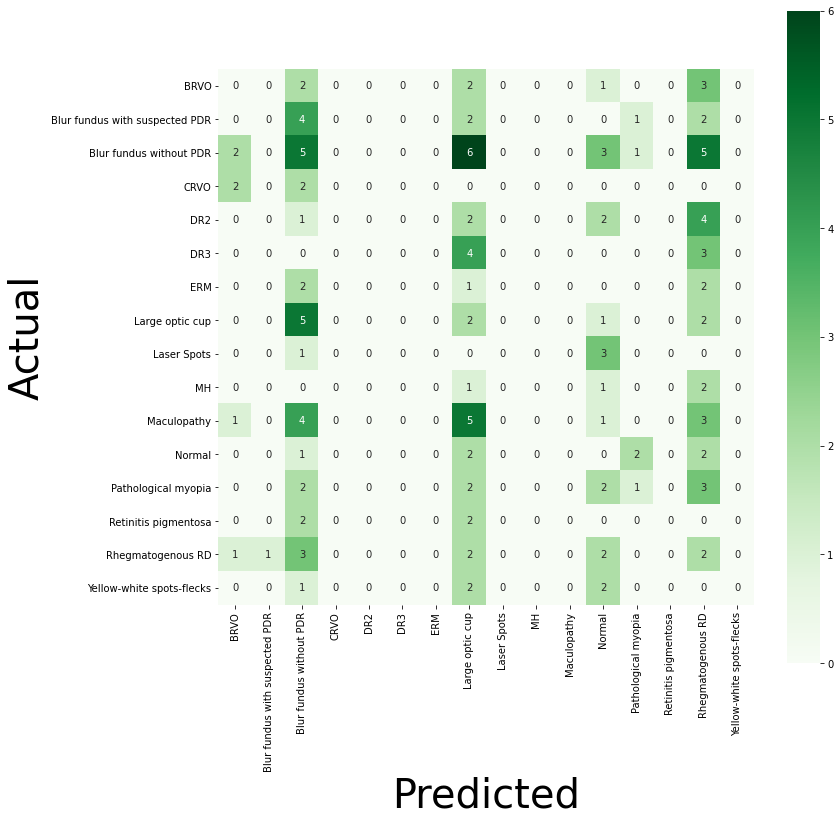

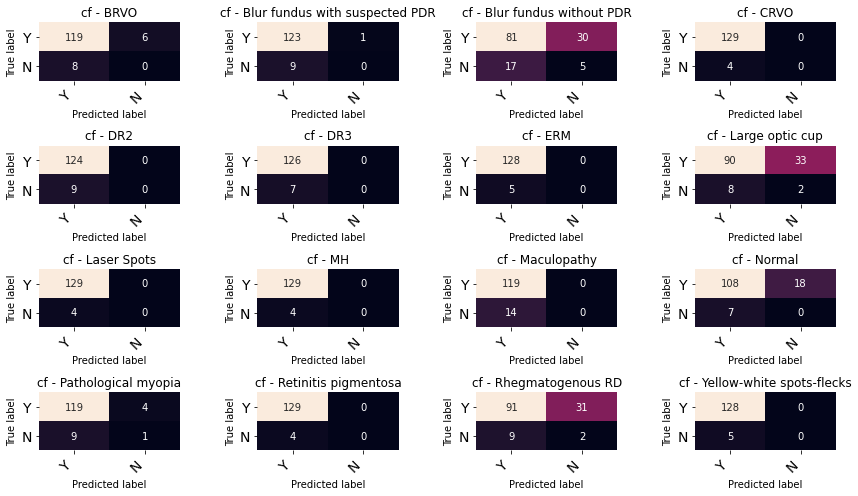

In [55]:
import sklearn.metrics
import seaborn as sns
y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

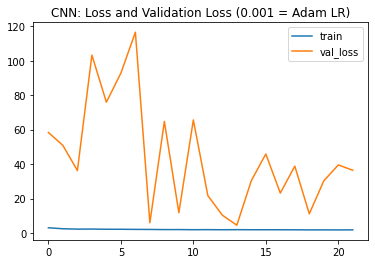

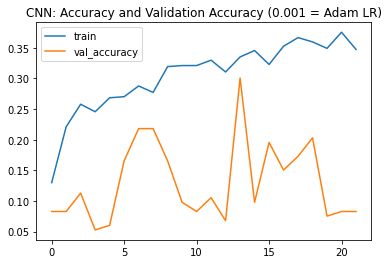

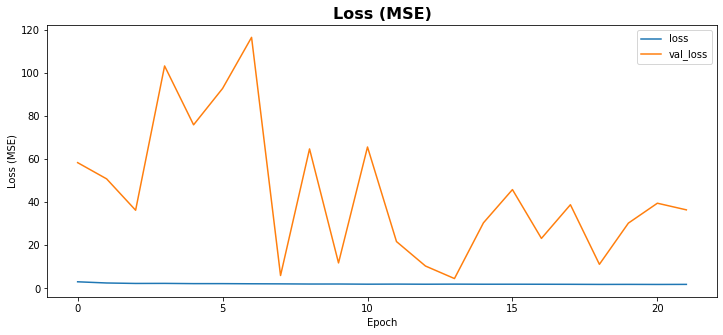

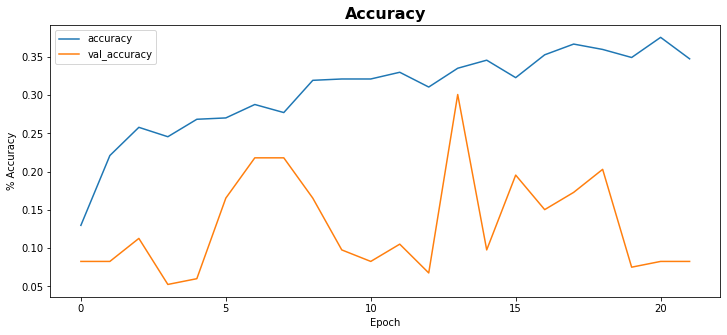

In [56]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.001 = Adam LR)')
plt.legend();
plt.show()


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");
plt.show()

In [57]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50
def get_model_resnet():
  base_model = ResNet50(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  #x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_resnet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [58]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 8,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.RMSprop(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)

Epoch 1/50
18/18 [==============================] - 86s 5s/step - loss: 4.7138 - accuracy: 0.0968 - val_loss: 24.9858 - val_accuracy: 0.0677
Epoch 2/50
18/18 [==============================] - 78s 4s/step - loss: 2.7311 - accuracy: 0.1443 - val_loss: 31.5212 - val_accuracy: 0.1654
Epoch 3/50
18/18 [==============================] - 78s 4s/step - loss: 2.5039 - accuracy: 0.2066 - val_loss: 19.3945 - val_accuracy: 0.1053
Epoch 4/50
18/18 [==============================] - 78s 4s/step - loss: 2.6013 - accuracy: 0.1628 - val_loss: 53.1502 - val_accuracy: 0.1053
Epoch 5/50
18/18 [==============================] - 77s 4s/step - loss: 2.3619 - accuracy: 0.2348 - val_loss: 30.7173 - val_accuracy: 0.0677
Epoch 6/50
18/18 [==============================] - 77s 4s/step - loss: 2.3527 - accuracy: 0.2291 - val_loss: 286.6488 - val_accuracy: 0.0752
Epoch 7/50
18/18 [==============================] - 77s 4s/step - loss: 2.3129 - accuracy: 0.2767 - val_loss: 42.8619 - val_accuracy: 0.1429
Epoch 8/50
1

In [59]:
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('resnet_adam.h5')

Test loss: 19.36406898498535
Test Accuracy: 0.09774436056613922


Confusion Matrix
[[ 0  0  0  0  1  0  0  7  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  8  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 22  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0 12  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0]]



F1 Score macro 0.009191176470588236
F1 Score micro 0.07518796992481203
F1 Score weighted 0.011057054400707653
accuracy_score  0.07518796992481203
precision_score  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



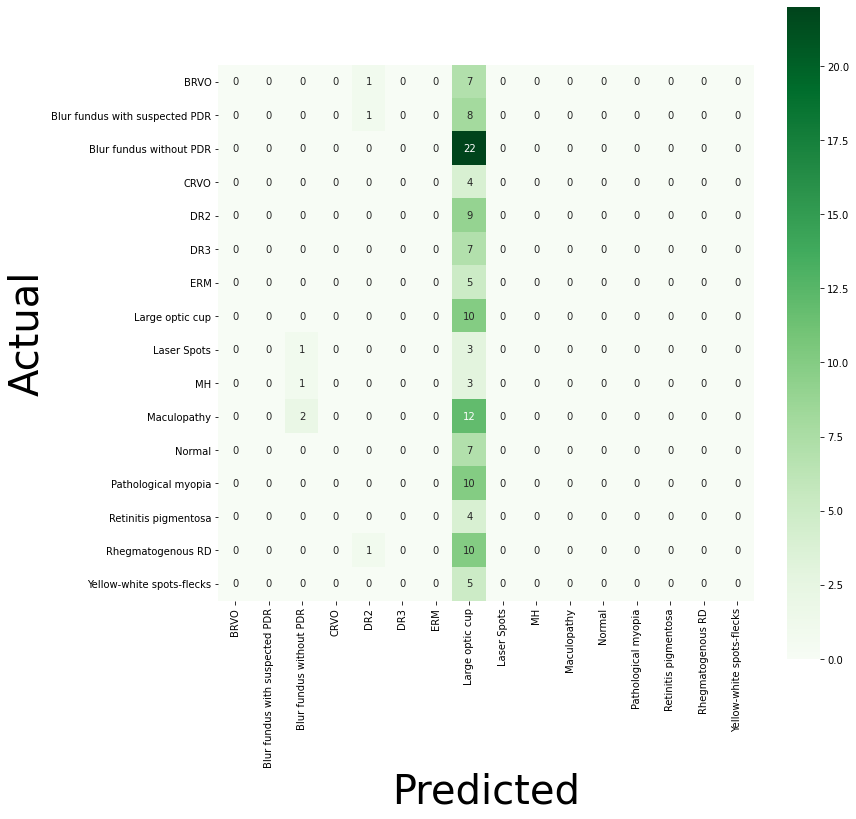

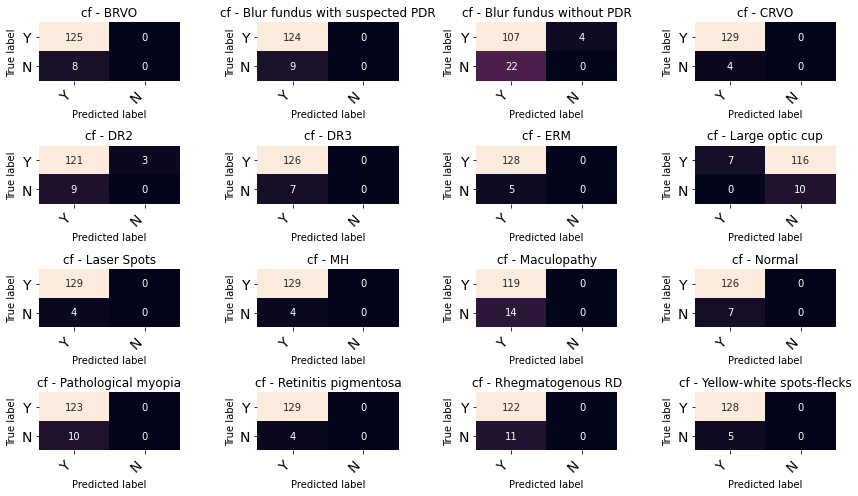

In [60]:
import sklearn.metrics
import seaborn as sns
y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

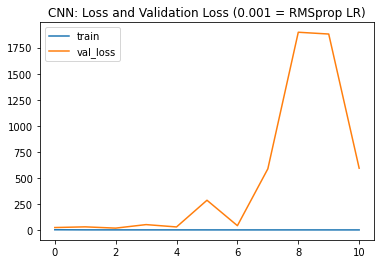

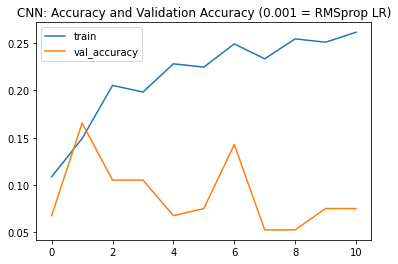

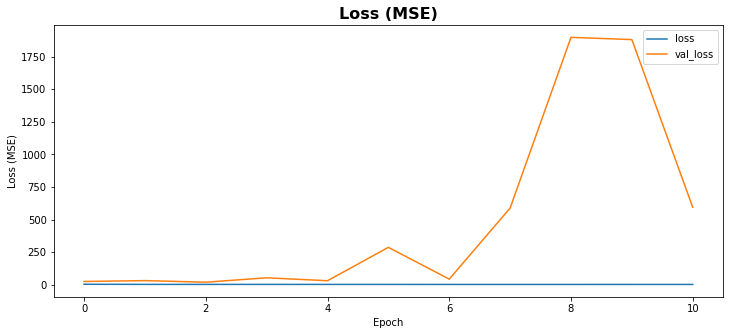

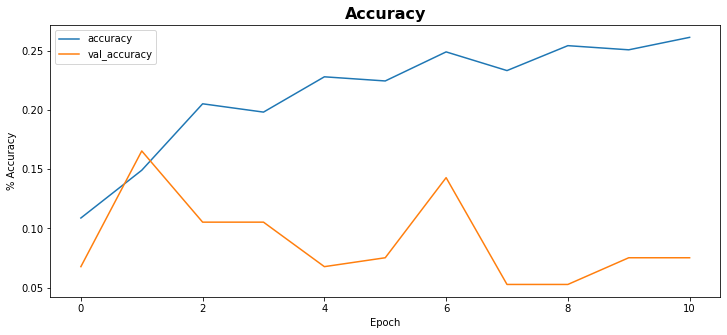

In [61]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.001 = RMSprop LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.001 = RMSprop LR)')
plt.legend();
plt.show()


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");
plt.show()

In [62]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50
def get_model_resnet():
  base_model = ResNet50(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='sigmoid')(x)
  #x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_resnet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [63]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 8,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/50
18/18 [==============================] - 85s 5s/step - loss: 2.6967 - accuracy: 0.1605 - val_loss: 2.7664 - val_accuracy: 0.0677
Epoch 2/50
18/18 [==============================] - 78s 4s/step - loss: 2.3067 - accuracy: 0.2389 - val_loss: 2.7711 - val_accuracy: 0.0827
Epoch 3/50
18/18 [==============================] - 78s 4s/step - loss: 2.2018 - accuracy: 0.2761 - val_loss: 2.7174 - val_accuracy: 0.0827
Epoch 4/50
18/18 [==============================] - 77s 4s/step - loss: 2.0768 - accuracy: 0.3116 - val_loss: 2.7214 - val_accuracy: 0.1504
Epoch 5/50
18/18 [==============================] - 78s 4s/step - loss: 1.9563 - accuracy: 0.3395 - val_loss: 3.0171 - val_accuracy: 0.0977
Epoch 6/50
18/18 [==============================] - 77s 4s/step - loss: 1.8740 - accuracy: 0.3555 - val_loss: 2.9472 - val_accuracy: 0.1579
Epoch 7/50
18/18 [==============================] - 77s 4s/step - loss: 1.8502 - accuracy: 0.3658 - val_loss: 3.8677 - val_accuracy: 0.1278
Epoch 8/50
18/18 [==

In [64]:
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('resnet_adam.h5')

Test loss: 3.00150990486145
Test Accuracy: 0.31578946113586426


Test loss: 2.941626787185669
Test Accuracy: 0.27819550037384033
Confusion Matrix
[[1 1 1 0 0 0 0 1 1 0 3 0 0 0 0 0]
 [2 0 0 0 0 0 0 3 0 0 0 0 0 0 4 0]
 [1 3 2 0 1 0 0 2 1 0 6 1 0 0 4 1]
 [0 1 1 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [2 1 0 0 0 0 0 0 0 0 1 0 0 0 5 0]
 [1 1 1 0 0 0 0 0 0 0 1 0 0 0 3 0]
 [1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0]
 [1 3 0 1 0 0 0 3 1 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0]
 [1 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [1 4 2 0 0 0 0 1 2 0 1 0 0 0 3 0]
 [0 2 1 1 0 0 0 1 0 0 1 0 0 0 1 0]
 [1 2 2 0 0 0 0 2 1 0 1 0 0 0 1 0]
 [1 0 1 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [3 1 1 0 0 0 0 1 1 0 1 0 0 0 3 0]
 [1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0]]



F1 Score macro 0.039027048319327726
F1 Score micro 0.07518796992481203
F1 Score weighted 0.059369116067479626
accuracy_score  0.07518796992481203
precision_score  0.03444754338517016
recall_score  0.05375405844155844
mean_squared_error  59.225563909774436


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



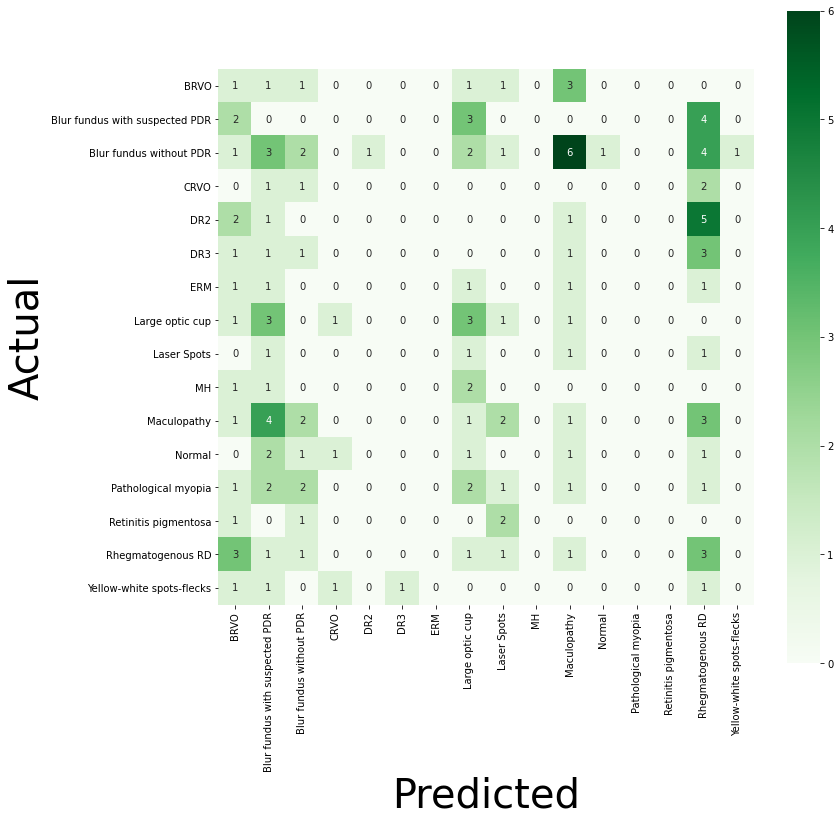

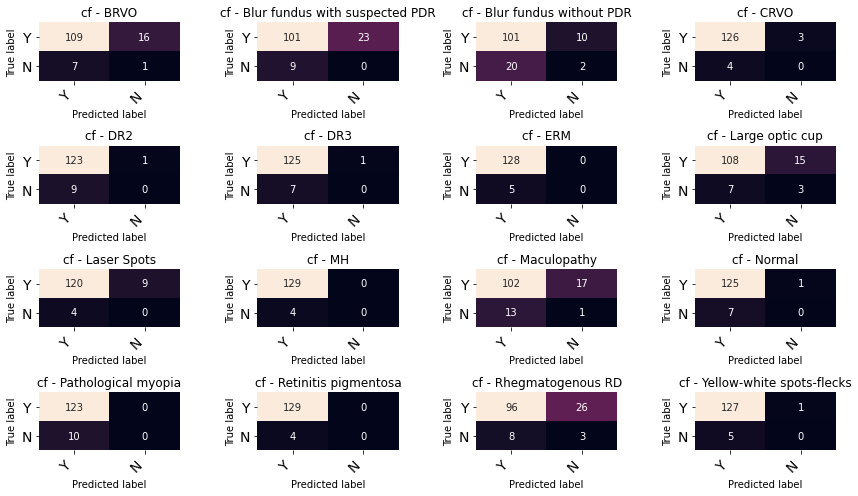

In [65]:
import sklearn.metrics
import seaborn as sns
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('resnet_adam.h5')

y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

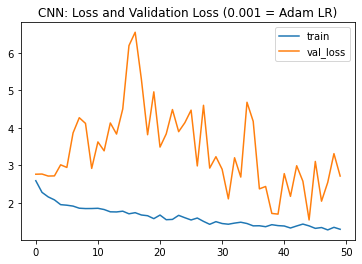

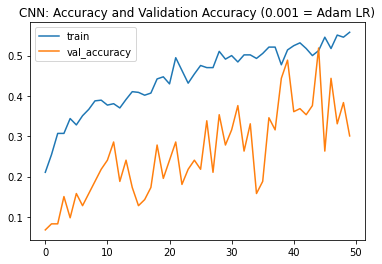

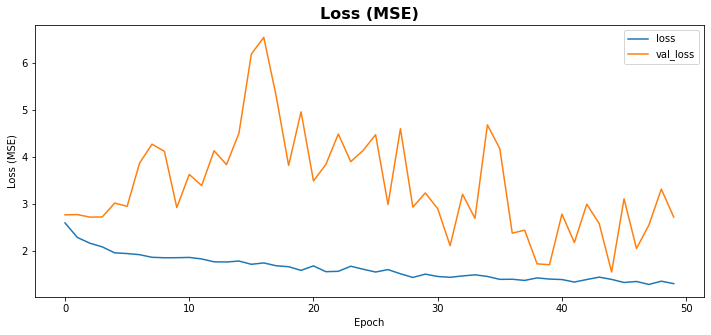

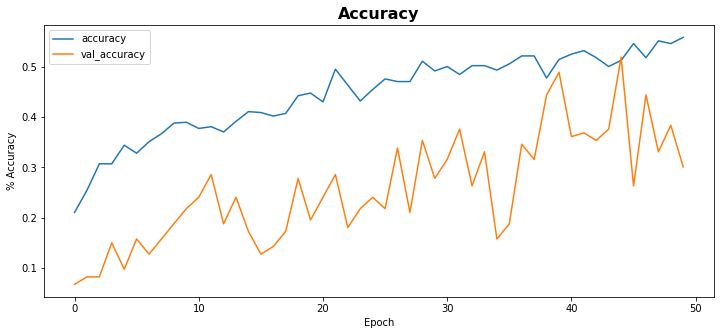

In [66]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.001 = Adam LR)')
plt.legend();
plt.show()


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");
plt.show()

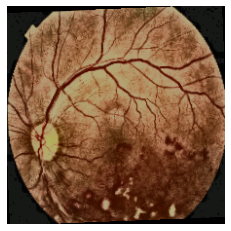

True label: BRVO
Predicted label: Large optic cup


In [67]:
def get_class_string_from_index(index):
   for class_string, class_index in val_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(val_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [68]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50
def get_model_resnet():
  base_model = ResNet50(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='sigmoid')(x)
  #x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_resnet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [69]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 8,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.Adamax(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)

Epoch 1/50
18/18 [==============================] - 86s 5s/step - loss: 2.7028 - accuracy: 0.1622 - val_loss: 2.7156 - val_accuracy: 0.0752
Epoch 2/50
18/18 [==============================] - 79s 4s/step - loss: 2.3417 - accuracy: 0.2797 - val_loss: 2.7330 - val_accuracy: 0.0752
Epoch 3/50
18/18 [==============================] - 79s 4s/step - loss: 2.2117 - accuracy: 0.3182 - val_loss: 2.7410 - val_accuracy: 0.0752
Epoch 4/50
18/18 [==============================] - 78s 4s/step - loss: 2.1697 - accuracy: 0.3112 - val_loss: 2.7323 - val_accuracy: 0.0827
Epoch 5/50
18/18 [==============================] - 78s 4s/step - loss: 2.0271 - accuracy: 0.3253 - val_loss: 2.7345 - val_accuracy: 0.0752
Epoch 6/50
18/18 [==============================] - 78s 4s/step - loss: 1.9619 - accuracy: 0.3532 - val_loss: 2.6609 - val_accuracy: 0.1053
Epoch 7/50
18/18 [==============================] - 79s 4s/step - loss: 1.8930 - accuracy: 0.3580 - val_loss: 2.5378 - val_accuracy: 0.2180
Epoch 8/50
18/18 [==

Test loss: 1.6549983024597168
Test Accuracy: 0.43609023094177246
Confusion Matrix
[[0 0 4 0 0 0 0 0 0 0 1 0 3 0 0 0]
 [2 0 2 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [2 1 3 0 1 1 0 5 0 0 4 0 2 0 3 0]
 [0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0]
 [2 2 0 0 1 0 0 1 0 0 3 0 0 0 0 0]
 [0 0 1 0 0 1 0 1 0 0 1 0 2 0 0 1]
 [1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0]
 [2 0 0 0 1 1 0 2 0 0 3 0 1 0 0 0]
 [0 0 2 0 0 0 0 1 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0 2 0 0 0 1 0]
 [1 2 4 1 1 0 0 1 0 0 2 0 2 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 5 0 1 0 0 0]
 [3 0 0 0 1 1 0 2 0 0 1 0 0 0 1 1]
 [0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 1 0 1 1 0 5 0 0 0 1 1]
 [1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0]]



F1 Score macro 0.06318681318681318
F1 Score micro 0.08270676691729323
F1 Score weighted 0.07630339585226802
accuracy_score  0.08270676691729323
precision_score  0.06478758169934641
recall_score  0.06713113275613275
mean_squared_error  40.93984962406015


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



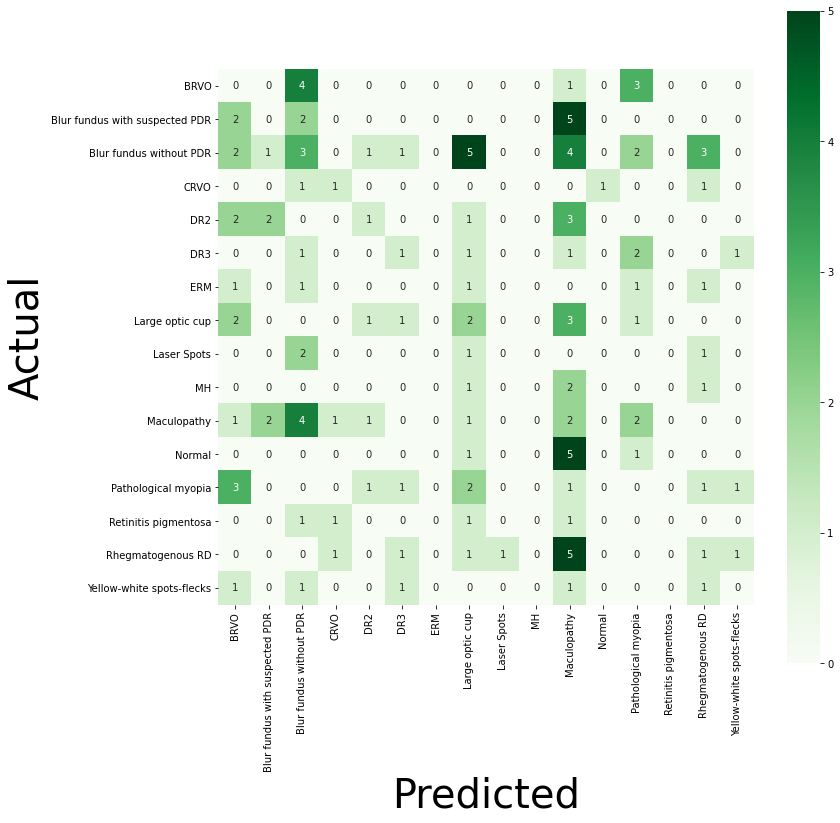

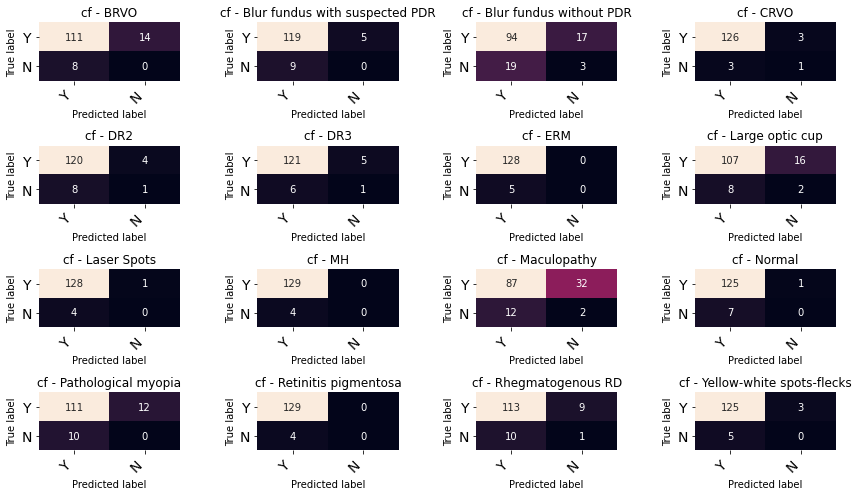

In [70]:
import sklearn.metrics
import seaborn as sns
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('resnet_adam.h5')

y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("cf - " + class_label)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

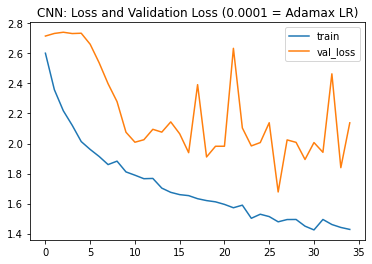

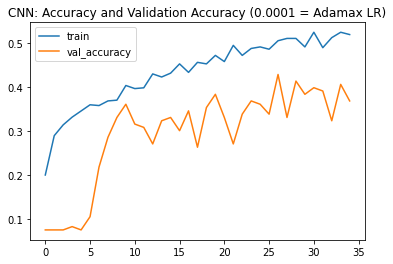

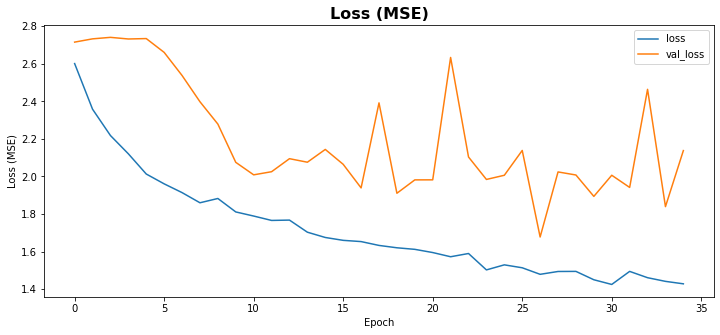

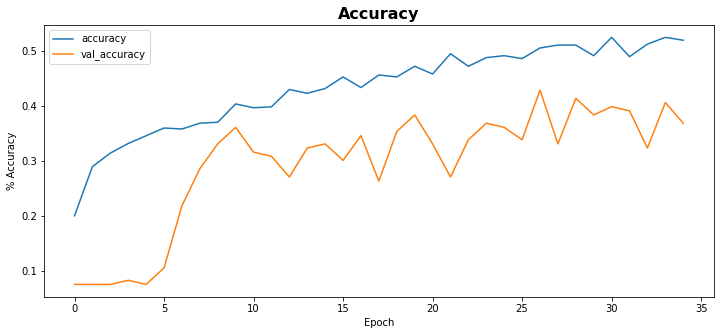

In [71]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = Adamax LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = Adamax LR)')
plt.legend();
plt.show()


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");
plt.show()

In [72]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50
def get_model_resnet():
  base_model = ResNet50(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(1024, activation='sigmoid')(x)
  #x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(len(Diseases), activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = True
  
  #model.summary()
  return model
model = get_model_resnet()
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:-50]:
    layer.trainable = False

In [73]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 8,  
                                        restore_best_weights = True) 
model.compile(keras.optimizers.RMSprop(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks = [earlystopping]
)

Epoch 1/50
18/18 [==============================] - 89s 5s/step - loss: 2.6997 - accuracy: 0.1459 - val_loss: 2.7845 - val_accuracy: 0.0827
Epoch 2/50
18/18 [==============================] - 81s 5s/step - loss: 2.3426 - accuracy: 0.2609 - val_loss: 2.8391 - val_accuracy: 0.0827
Epoch 3/50
18/18 [==============================] - 81s 5s/step - loss: 2.1794 - accuracy: 0.2805 - val_loss: 2.6000 - val_accuracy: 0.2030
Epoch 4/50
18/18 [==============================] - 79s 4s/step - loss: 2.1193 - accuracy: 0.3004 - val_loss: 2.6471 - val_accuracy: 0.1955
Epoch 5/50
18/18 [==============================] - 79s 4s/step - loss: 1.9804 - accuracy: 0.3502 - val_loss: 2.4200 - val_accuracy: 0.2030
Epoch 6/50
18/18 [==============================] - 79s 4s/step - loss: 2.0107 - accuracy: 0.3454 - val_loss: 2.8070 - val_accuracy: 0.1203
Epoch 7/50
18/18 [==============================] - 79s 4s/step - loss: 2.0259 - accuracy: 0.3034 - val_loss: 3.1030 - val_accuracy: 0.1955
Epoch 8/50
18/18 [==

Test loss: 1.7086834907531738
Test Accuracy: 0.43609023094177246
Confusion Matrix
[[2 0 2 1 0 0 0 0 1 0 0 0 1 0 1 0]
 [0 0 3 0 0 2 0 0 0 0 2 0 0 0 2 0]
 [1 1 6 0 0 1 0 2 0 0 4 0 3 0 2 2]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 2 1]
 [0 0 1 0 1 0 0 3 0 0 3 0 1 0 0 0]
 [0 0 1 0 1 1 0 1 0 0 2 0 0 0 1 0]
 [0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0]
 [1 1 3 1 1 1 0 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 2 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 1]
 [0 3 1 0 0 0 0 1 1 0 4 0 2 0 1 1]
 [0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 2]
 [0 1 1 0 1 0 0 2 0 0 2 0 1 0 0 2]
 [0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1]
 [0 1 1 0 0 0 0 1 0 0 7 0 0 0 0 1]
 [0 0 0 1 0 0 0 1 0 0 1 0 0 0 2 0]]



F1 Score macro 0.07911232384636639
F1 Score micro 0.12030075187969924
F1 Score weighted 0.1150528296424953
accuracy_score  0.12030075187969924
precision_score  0.09128787878787878
recall_score  0.07890061327561326
mean_squared_error  39.26315789473684


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



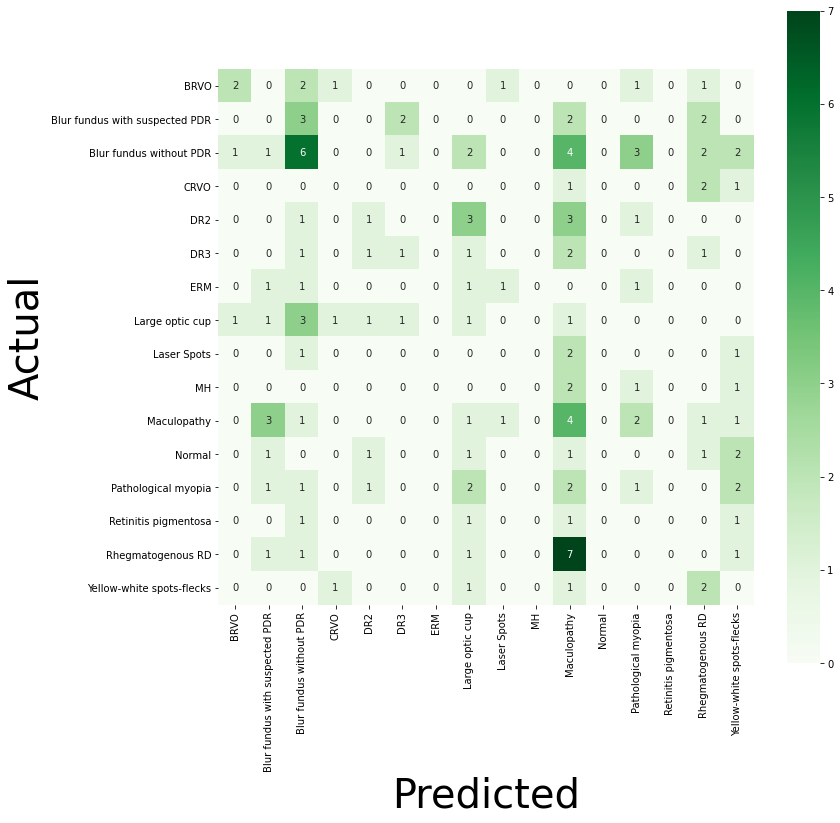

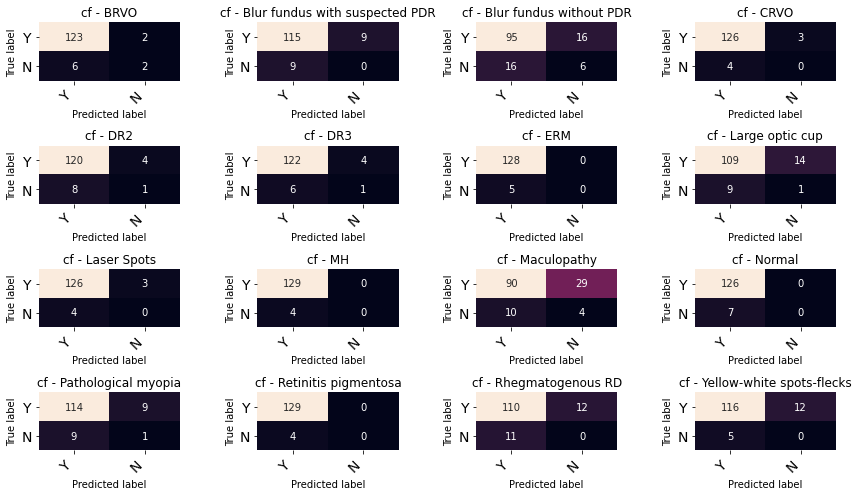

In [74]:
import sklearn.metrics
import seaborn as sns
def model_evaluation(model):
    loss, acc = model.evaluate(val_generator,verbose=0)
    print('Test loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(acc))
model_evaluation(model)
model.save('resnet_adam.h5')

y_pred = model.predict(val_generator)
y_pred1 = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = sklearn.metrics.confusion_matrix(val_generator.classes, y_pred1)
print(cm)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=Diseases, yticklabels=Diseases)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
print ("\n\n")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error,multilabel_confusion_matrix
print("F1 Score macro",f1_score(val_generator.classes, y_pred1, average='macro'))
print("F1 Score micro", f1_score(val_generator.classes, y_pred1, average='micro'))
print("F1 Score weighted", f1_score(val_generator.classes, y_pred1, average='weighted'))
print("accuracy_score ", accuracy_score(val_generator.classes, y_pred1))
print("precision_score ", precision_score(val_generator.classes, y_pred1, average='macro'))
print("recall_score ", recall_score(val_generator.classes, y_pred1, average='macro'))
print("mean_squared_error ", mean_squared_error(val_generator.classes, y_pred1))
#print("multilabel_confusion_matrix",multilabel_confusion_matrix(val_generator.classes, y_pred1))
#print("roc_auc_score ovo", roc_auc_score(val_generator.classes, y_pred1, average='macro', multi_class='ovo'))
vis_arr = multilabel_confusion_matrix(val_generator.classes, y_pred1)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, Diseases):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
    
fig.tight_layout()
plt.show()

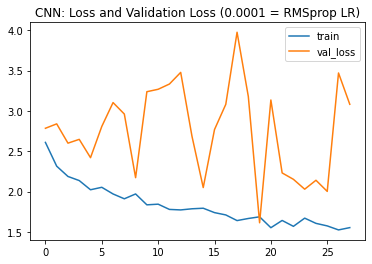

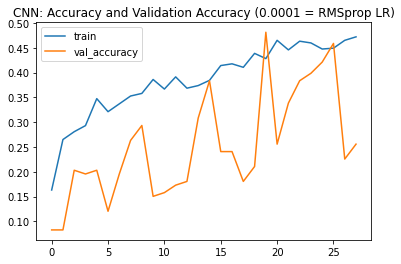

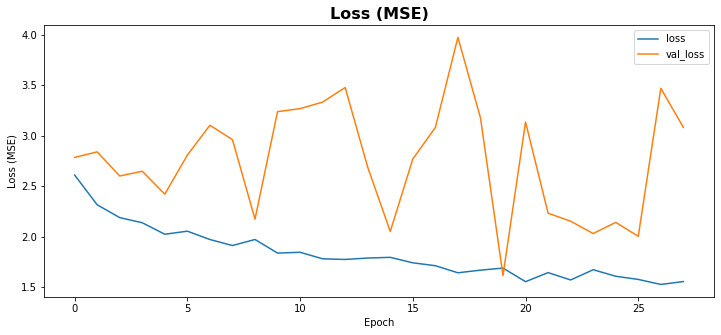

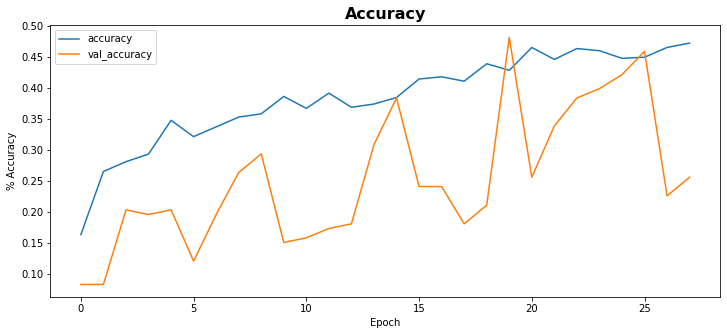

In [75]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN: Loss and Validation Loss (0.0001 = RMSprop LR)')
plt.legend();
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('CNN: Accuracy and Validation Accuracy (0.0001 = RMSprop LR)')
plt.legend();
plt.show()


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");
plt.show()